# Setup

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


'ghp_z(HayhkIaeF11Invg1KGWKjWYvfi150358zH'

ghp_z(HayhkIaeF11Invg1KGWKjWYvfi150358zH

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# UNDERFITTING - occurs when the model cannot obtain a low enough loss on the training set => model fails to learn the underlying patters in the training data

# OVERFITTING - where network models the training data too well + fails to generalize to the validation data

# goal is to reduce training loss + ensure gap between training & testing loss is small

# control fitting by adjusting CAPACITY of the network
    # increase it by adding layers + neurons => reach "optimal" of network
    # decrease it by removing layers & neurons + using regularization methods

# training & validation loss/accuracy start to diverge from each other => noticeable gap => GOAL is to limit the gap => preserve the generalizability of the model
    # if gap isnt limited => "OVERFITTING ZONE" => training loss will either stagnate/continue to drop + validation loss stagnates & increases (heavy indicator of overfitting)

# combat overfitting? reduce complexity (less layers & neurons) + applying regularization methods (weight decay, dropout, data augmentation)

# import the necessary packages
from keras.callbacks import BaseLogger # used to create a class that logs the losses & acccuracy to the disk
import matplotlib.pyplot as plt
import numpy as np
import json
import os

class TrainingMonitor(BaseLogger):

    def __init__(self, figPath, jsonPath=None, startAt=0):
    
        # figPath = path to output plot thay can be used to visualize loss & accuracy over time
        # jsonPath = path used to serialize the loss & accuracy values as a JSON file (useful to see the training history to create custome plots)
        # startAt = staring epoch that training is resumed at using ctrl + c training
        
        
        # store the output path for the figure, the path to the JSON serialized file, and the starting epoch
        super(TrainingMonitor, self).__init__()
        self.figPath = figPath
        self.jsonPath = jsonPath
        self.startAt = startAt
        
    def on_train_begin(self, logs={}):
    
        # initialize the history dictionary ("history" of losses)
        self.H = {}
     
        # if the JSON history path exists, load the training history
        if self.jsonPath is not None:
            if os.path.exists(self.jsonPath):
                self.H = json.loads(open(self.jsonPath).read())
               
                # check to see if a starting epoch was supplied
                if self.startAt > 0:
                    # loop over the entries in the history log and trim any entries that are past the starting epoch
                    for k in self.H.keys():
                         self.H[k] = self.H[k][:self.startAt]

    def on_epoch_end(self, epoch, logs={}): # is called when a training epoch completes
        # epoch = epoch #
        # logs = contains the training & validation loss + accuracy for current epoch
    
        # loop over the logs and update the loss, accuracy, etc. for the entire training process
        for (k, v) in logs.items():
            l = self.H.get(k, [])
            l.append(v)
            self.H[k] = l
            
            #after code is executed H has 4 keys (train_loss, train_accuracy, val_loss, val_accuracy) => a list is kept for each of the values => each list is updated after every epoch => plot an updated loss & accuracy curve as soon as the epoch completes
            
        # check to see if the training history should be serialized to file
        if self.jsonPath is not None:
            f = open(self.jsonPath, "w")
            f.write(json.dumps(self.H))
            f.close()

        # ensure at least two epochs have passed before plotting (epoch starts at zero)
        if len(self.H["loss"]) > 1:
            # plot the training loss and accuracy
            N = np.arange(0, len(self.H["loss"]))
            plt.style.use("ggplot")
            plt.figure()
            plt.plot(N, self.H["loss"], label="train_loss")
            plt.plot(N, self.H["val_loss"], label="val_loss")
            plt.plot(N, self.H["accuracy"], label="train_accuracy")
            plt.plot(N, self.H["val_accuracy"], label="val_accuracy")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(len(self.H["loss"])))
            plt.xlabel("Epoch Number")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            
            # save the figure
            plt.savefig(self.figPath)
            plt.close()

# Antrenare pe modelul ResNet50

Se va schimba modelul EmotionVGG creat mai sus cu modelul ResNet50 pentru a testa pe un model preantrenat.

In plus, se va face fine-tuning cu un strat de 512 de neuroni. Spre deosebire de 3.4, se va modifica modelul cu cel ResNet50.

Rezultatele se salveaza in outputs/output33.



---

ANTRENARE

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os
import tensorflow
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output33'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output33/checkpoint1'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (224, 224), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (224, 224), batch_size = 128, class_mode = 'categorical')


# FOLOSIRE VGG16

## Loading VGG16 model

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False ## Not trainable weights

## Add last layers

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer = layers.Dropout(0.5)
prediction_layer = layers.Dense(6, activation='softmax')


model = models.Sequential([base_model, flatten_layer, dense_layer_1, dropout_layer, prediction_layer])

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.
94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
print("[INFO] base model status... \n")
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

print("\n\n[INFO] entire model status...\n")
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

[INFO] base model status... 

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_

In [ ]:
## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition33_1.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognitio33_1.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 20, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

[INFO] compiling model...
Epoch 1/20
16/33 [=============>................] - ETA: 32s - loss: 1.7746 - accuracy: 0.2147

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 102s 3s/step - loss: 1.7573 - accuracy: 0.2363 - val_loss: 1.7029 - val_accuracy: 0.3281
Epoch 2/20
32/33 [============================>.] - ETA: 1s - loss: 1.7340 - accuracy: 0.2471

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 86s 3s/step - loss: 1.7338 - accuracy: 0.2484 - val_loss: 1.6894 - val_accuracy: 0.3301
Epoch 3/20
12/33 [=========>....................] - ETA: 42s - loss: 1.7133 - accuracy: 0.2819

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 64s 2s/step - loss: 1.7065 - accuracy: 0.2834 - val_loss: 1.6633 - val_accuracy: 0.2969
Epoch 4/20
19/33 [================>.............] - ETA: 24s - loss: 1.6950 - accuracy: 0.2854

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 80s 2s/step - loss: 1.6968 - accuracy: 0.2773 - val_loss: 1.6496 - val_accuracy: 0.3340
Epoch 5/20
 2/33 [>.............................] - ETA: 49s - loss: 1.6915 - accuracy: 0.2891 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 79s 2s/step - loss: 1.6823 - accuracy: 0.2981 - val_loss: 1.6278 - val_accuracy: 0.3359
Epoch 6/20
 3/33 [=>............................] - ETA: 47s - loss: 1.6977 - accuracy: 0.2917

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.6694 - accuracy: 0.2980 - val_loss: 1.6028 - val_accuracy: 0.3301
Epoch 7/20


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6545 - accuracy: 0.3116 - val_loss: 1.6012 - val_accuracy: 0.3340
Epoch 8/20


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 77s 2s/step - loss: 1.6492 - accuracy: 0.3137 - val_loss: 1.5881 - val_accuracy: 0.3457
Epoch 9/20
 4/33 [==>...........................] - ETA: 47s - loss: 1.6846 - accuracy: 0.2949

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.6444 - accuracy: 0.3099 - val_loss: 1.5824 - val_accuracy: 0.3164
Epoch 10/20
13/33 [==========>...................] - ETA: 33s - loss: 1.6226 - accuracy: 0.3215

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6251 - accuracy: 0.3218 - val_loss: 1.5817 - val_accuracy: 0.3359
Epoch 11/20
 1/33 [..............................] - ETA: 1:05 - loss: 1.6619 - accuracy: 0.3828

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6163 - accuracy: 0.3220 - val_loss: 1.5461 - val_accuracy: 0.3398
Epoch 12/20
24/33 [====================>.........] - ETA: 14s - loss: 1.6101 - accuracy: 0.3230

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 78s 2s/step - loss: 1.6111 - accuracy: 0.3249 - val_loss: 1.5485 - val_accuracy: 0.3594
Epoch 13/20
28/33 [========================>.....] - ETA: 8s - loss: 1.6076 - accuracy: 0.3292

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6133 - accuracy: 0.3269 - val_loss: 1.5379 - val_accuracy: 0.3477
Epoch 14/20
 5/33 [===>..........................] - ETA: 46s - loss: 1.6361 - accuracy: 0.3000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 75s 2s/step - loss: 1.5992 - accuracy: 0.3196 - val_loss: 1.5258 - val_accuracy: 0.3730
Epoch 15/20
 4/33 [==>...........................] - ETA: 34s - loss: 1.6149 - accuracy: 0.3251

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5890 - accuracy: 0.3329 - val_loss: 1.5258 - val_accuracy: 0.3555
Epoch 16/20
19/33 [================>.............] - ETA: 21s - loss: 1.5934 - accuracy: 0.3452

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5981 - accuracy: 0.3344 - val_loss: 1.5188 - val_accuracy: 0.3438
Epoch 17/20
21/33 [==================>...........] - ETA: 18s - loss: 1.5855 - accuracy: 0.3311

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.5822 - accuracy: 0.3320 - val_loss: 1.4969 - val_accuracy: 0.3613
Epoch 18/20
14/33 [===========>..................] - ETA: 30s - loss: 1.5839 - accuracy: 0.3281

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 75s 2s/step - loss: 1.5854 - accuracy: 0.3358 - val_loss: 1.5004 - val_accuracy: 0.3750
Epoch 19/20
21/33 [==================>...........] - ETA: 19s - loss: 1.5710 - accuracy: 0.3517

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5605 - accuracy: 0.3543 - val_loss: 1.5044 - val_accuracy: 0.3711
Epoch 20/20
 5/33 [===>..........................] - ETA: 44s - loss: 1.5801 - accuracy: 0.3297

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.5713 - accuracy: 0.3363 - val_loss: 1.4907 - val_accuracy: 0.3750




---

TESTARE

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output33/checkpoint1'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (224, 224), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("\n\n[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output33/checkpoint1...
4/4 [==============================] - 84s 27s/step - loss: 1.5456 - accuracy: 0.3496
              precision    recall  f1-score   support

           0       0.17      0.49      0.25        96
           1       0.16      0.15      0.15        81
           2       0.25      0.18      0.21        99
           3       0.09      0.06      0.07        94
           4       0.09      0.01      0.02        88
           5       0.17      0.09      0.11        82

    accuracy                           0.17       540
   macro avg       0.16      0.16      0.14       540
weighted avg       0.16      0.17      0.14       540



[INFO] accuracy: 34.96




---



---

ANTRENARE

In [ ]:
output = '/content/drive/MyDrive/GitHub/licenta/outputs/output33'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output33/checkpoint2'
start_epoch = 0

for layer in base_model.layers[168:]:
  layer.trainable = True

print("[INFO] base model status... \n")
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

print("\n\n[INFO] entire model status...\n\n")
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

[INFO] base model status... 

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_

In [ ]:
## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition33_2.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition33_2.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 100, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

[INFO] compiling model...
Epoch 1/100
 5/33 [===>..........................] - ETA: 44s - loss: 1.6214 - accuracy: 0.3047

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 80s 2s/step - loss: 1.5909 - accuracy: 0.3150 - val_loss: 1.5199 - val_accuracy: 0.3652
Epoch 2/100
12/33 [=========>....................] - ETA: 33s - loss: 1.5673 - accuracy: 0.3287

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 78s 2s/step - loss: 1.5676 - accuracy: 0.3329 - val_loss: 1.4967 - val_accuracy: 0.3809
Epoch 3/100
31/33 [===========================>..] - ETA: 3s - loss: 1.5565 - accuracy: 0.3480

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 59s 2s/step - loss: 1.5623 - accuracy: 0.3441 - val_loss: 1.4876 - val_accuracy: 0.3672
Epoch 4/100
20/33 [=================>............] - ETA: 20s - loss: 1.5537 - accuracy: 0.3350

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.5662 - accuracy: 0.3388 - val_loss: 1.4971 - val_accuracy: 0.3789
Epoch 5/100
20/33 [=================>............] - ETA: 21s - loss: 1.5353 - accuracy: 0.3492

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5586 - accuracy: 0.3378 - val_loss: 1.5007 - val_accuracy: 0.3750
Epoch 6/100
24/33 [====================>.........] - ETA: 14s - loss: 1.5449 - accuracy: 0.3418

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.5512 - accuracy: 0.3423 - val_loss: 1.4853 - val_accuracy: 0.3750
Epoch 7/100
 5/33 [===>..........................] - ETA: 45s - loss: 1.5793 - accuracy: 0.3219

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5482 - accuracy: 0.3499 - val_loss: 1.4753 - val_accuracy: 0.3750
Epoch 8/100
23/33 [===================>..........] - ETA: 16s - loss: 1.5413 - accuracy: 0.3495

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 59s 2s/step - loss: 1.5524 - accuracy: 0.3494 - val_loss: 1.4827 - val_accuracy: 0.3633
Epoch 9/100
10/33 [========>.....................] - ETA: 38s - loss: 1.5397 - accuracy: 0.3484

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 78s 2s/step - loss: 1.5382 - accuracy: 0.3543 - val_loss: 1.4674 - val_accuracy: 0.3828
Epoch 10/100
31/33 [===========================>..] - ETA: 3s - loss: 1.5397 - accuracy: 0.3441

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5403 - accuracy: 0.3448 - val_loss: 1.4817 - val_accuracy: 0.3770
Epoch 11/100
16/33 [=============>................] - ETA: 27s - loss: 1.5370 - accuracy: 0.3579

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.5323 - accuracy: 0.3524 - val_loss: 1.4617 - val_accuracy: 0.3750
Epoch 12/100
 4/33 [==>...........................] - ETA: 48s - loss: 1.5024 - accuracy: 0.3867

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 78s 2s/step - loss: 1.5329 - accuracy: 0.3434 - val_loss: 1.4528 - val_accuracy: 0.3848
Epoch 13/100
23/33 [===================>..........] - ETA: 16s - loss: 1.5128 - accuracy: 0.3499

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.5118 - accuracy: 0.3480 - val_loss: 1.4543 - val_accuracy: 0.3711
Epoch 14/100
30/33 [==========================>...] - ETA: 4s - loss: 1.5216 - accuracy: 0.3495

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 78s 2s/step - loss: 1.5201 - accuracy: 0.3497 - val_loss: 1.4551 - val_accuracy: 0.3867
Epoch 15/100
24/33 [====================>.........] - ETA: 15s - loss: 1.5324 - accuracy: 0.3520

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5336 - accuracy: 0.3511 - val_loss: 1.4475 - val_accuracy: 0.3770
Epoch 16/100
30/33 [==========================>...] - ETA: 4s - loss: 1.5173 - accuracy: 0.3602

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5185 - accuracy: 0.3606 - val_loss: 1.4499 - val_accuracy: 0.3828
Epoch 17/100
15/33 [============>.................] - ETA: 29s - loss: 1.5157 - accuracy: 0.3547

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.5121 - accuracy: 0.3584 - val_loss: 1.4381 - val_accuracy: 0.3867
Epoch 18/100
14/33 [===========>..................] - ETA: 31s - loss: 1.5298 - accuracy: 0.3622

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5061 - accuracy: 0.3645 - val_loss: 1.4427 - val_accuracy: 0.3770
Epoch 19/100
26/33 [======================>.......] - ETA: 11s - loss: 1.5096 - accuracy: 0.3613

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5129 - accuracy: 0.3611 - val_loss: 1.4549 - val_accuracy: 0.3789
Epoch 20/100
31/33 [===========================>..] - ETA: 3s - loss: 1.5056 - accuracy: 0.3664

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5070 - accuracy: 0.3681 - val_loss: 1.4391 - val_accuracy: 0.3789
Epoch 21/100
11/33 [=========>....................] - ETA: 36s - loss: 1.5162 - accuracy: 0.3516

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.5100 - accuracy: 0.3579 - val_loss: 1.4359 - val_accuracy: 0.3809
Epoch 22/100
11/33 [=========>....................] - ETA: 34s - loss: 1.5106 - accuracy: 0.3564

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5225 - accuracy: 0.3485 - val_loss: 1.4473 - val_accuracy: 0.3672
Epoch 23/100
23/33 [===================>..........] - ETA: 15s - loss: 1.5121 - accuracy: 0.3531

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.5185 - accuracy: 0.3536 - val_loss: 1.4485 - val_accuracy: 0.3828
Epoch 24/100
22/33 [===================>..........] - ETA: 17s - loss: 1.4885 - accuracy: 0.3720

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4958 - accuracy: 0.3672 - val_loss: 1.4372 - val_accuracy: 0.3770
Epoch 25/100
16/33 [=============>................] - ETA: 26s - loss: 1.5125 - accuracy: 0.3460

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 78s 2s/step - loss: 1.5058 - accuracy: 0.3511 - val_loss: 1.4413 - val_accuracy: 0.3965
Epoch 26/100


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5083 - accuracy: 0.3626 - val_loss: 1.4299 - val_accuracy: 0.3887
Epoch 27/100
14/33 [===========>..................] - ETA: 29s - loss: 1.4944 - accuracy: 0.3387

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 76s 2s/step - loss: 1.4915 - accuracy: 0.3533 - val_loss: 1.4390 - val_accuracy: 0.3984
Epoch 28/100
 6/33 [====>.........................] - ETA: 43s - loss: 1.4773 - accuracy: 0.3555

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4973 - accuracy: 0.3613 - val_loss: 1.4236 - val_accuracy: 0.3887
Epoch 29/100
15/33 [============>.................] - ETA: 29s - loss: 1.4929 - accuracy: 0.3755

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4969 - accuracy: 0.3667 - val_loss: 1.4274 - val_accuracy: 0.3867
Epoch 30/100
21/33 [==================>...........] - ETA: 19s - loss: 1.4906 - accuracy: 0.3508

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4944 - accuracy: 0.3601 - val_loss: 1.4185 - val_accuracy: 0.3789
Epoch 31/100
10/33 [========>.....................] - ETA: 37s - loss: 1.4655 - accuracy: 0.3742

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4925 - accuracy: 0.3621 - val_loss: 1.4094 - val_accuracy: 0.3789
Epoch 32/100
32/33 [============================>.] - ETA: 1s - loss: 1.4828 - accuracy: 0.3752

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4823 - accuracy: 0.3749 - val_loss: 1.4394 - val_accuracy: 0.3691
Epoch 33/100
 6/33 [====>.........................] - ETA: 44s - loss: 1.4633 - accuracy: 0.3672

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4863 - accuracy: 0.3694 - val_loss: 1.4385 - val_accuracy: 0.3828
Epoch 34/100
15/33 [============>.................] - ETA: 27s - loss: 1.4872 - accuracy: 0.3622

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 78s 2s/step - loss: 1.4808 - accuracy: 0.3594 - val_loss: 1.4009 - val_accuracy: 0.4004
Epoch 35/100
23/33 [===================>..........] - ETA: 16s - loss: 1.4645 - accuracy: 0.3795

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4700 - accuracy: 0.3783 - val_loss: 1.4271 - val_accuracy: 0.3926
Epoch 36/100
29/33 [=========================>....] - ETA: 6s - loss: 1.4689 - accuracy: 0.3680

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4741 - accuracy: 0.3647 - val_loss: 1.4226 - val_accuracy: 0.3945
Epoch 37/100


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4761 - accuracy: 0.3638 - val_loss: 1.4120 - val_accuracy: 0.3906
Epoch 38/100
29/33 [=========================>....] - ETA: 6s - loss: 1.4853 - accuracy: 0.3712

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4838 - accuracy: 0.3684 - val_loss: 1.4208 - val_accuracy: 0.3809
Epoch 39/100
27/33 [=======================>......] - ETA: 9s - loss: 1.4892 - accuracy: 0.3522 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4911 - accuracy: 0.3577 - val_loss: 1.4153 - val_accuracy: 0.3809
Epoch 40/100
15/33 [============>.................] - ETA: 29s - loss: 1.4849 - accuracy: 0.3552

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4790 - accuracy: 0.3618 - val_loss: 1.4139 - val_accuracy: 0.3926
Epoch 41/100
20/33 [=================>............] - ETA: 20s - loss: 1.4807 - accuracy: 0.3692

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4701 - accuracy: 0.3754 - val_loss: 1.3965 - val_accuracy: 0.3809
Epoch 42/100
14/33 [===========>..................] - ETA: 31s - loss: 1.4846 - accuracy: 0.3460

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4684 - accuracy: 0.3611 - val_loss: 1.4034 - val_accuracy: 0.3926
Epoch 43/100
28/33 [========================>.....] - ETA: 8s - loss: 1.4879 - accuracy: 0.3683

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4843 - accuracy: 0.3707 - val_loss: 1.4185 - val_accuracy: 0.4004
Epoch 44/100
26/33 [======================>.......] - ETA: 11s - loss: 1.4768 - accuracy: 0.3752

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4738 - accuracy: 0.3759 - val_loss: 1.3939 - val_accuracy: 0.3887
Epoch 45/100
19/33 [================>.............] - ETA: 21s - loss: 1.4783 - accuracy: 0.3641

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4698 - accuracy: 0.3706 - val_loss: 1.3923 - val_accuracy: 0.3965
Epoch 46/100
32/33 [============================>.] - ETA: 1s - loss: 1.4706 - accuracy: 0.3747

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 76s 2s/step - loss: 1.4713 - accuracy: 0.3752 - val_loss: 1.4026 - val_accuracy: 0.4043
Epoch 47/100
18/33 [===============>..............] - ETA: 25s - loss: 1.4733 - accuracy: 0.3507

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4683 - accuracy: 0.3582 - val_loss: 1.4076 - val_accuracy: 0.3906
Epoch 48/100
28/33 [========================>.....] - ETA: 7s - loss: 1.4672 - accuracy: 0.3824

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4647 - accuracy: 0.3803 - val_loss: 1.3956 - val_accuracy: 0.3750
Epoch 49/100
14/33 [===========>..................] - ETA: 31s - loss: 1.4708 - accuracy: 0.3471

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4652 - accuracy: 0.3740 - val_loss: 1.3921 - val_accuracy: 0.4004
Epoch 50/100
10/33 [========>.....................] - ETA: 37s - loss: 1.4779 - accuracy: 0.3602

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4772 - accuracy: 0.3604 - val_loss: 1.4140 - val_accuracy: 0.3867
Epoch 51/100
 7/33 [=====>........................] - ETA: 41s - loss: 1.4723 - accuracy: 0.3850

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4527 - accuracy: 0.3856 - val_loss: 1.3883 - val_accuracy: 0.4004
Epoch 52/100
 2/33 [>.............................] - ETA: 51s - loss: 1.4644 - accuracy: 0.4180 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4633 - accuracy: 0.3725 - val_loss: 1.4048 - val_accuracy: 0.3945
Epoch 53/100
 2/33 [>.............................] - ETA: 48s - loss: 1.4786 - accuracy: 0.3945 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4520 - accuracy: 0.3757 - val_loss: 1.3971 - val_accuracy: 0.3984
Epoch 54/100
30/33 [==========================>...] - ETA: 4s - loss: 1.4618 - accuracy: 0.3771

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4601 - accuracy: 0.3715 - val_loss: 1.4221 - val_accuracy: 0.3887
Epoch 55/100
 7/33 [=====>........................] - ETA: 42s - loss: 1.4740 - accuracy: 0.3616

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4587 - accuracy: 0.3803 - val_loss: 1.3927 - val_accuracy: 0.4023
Epoch 56/100
22/33 [===================>..........] - ETA: 17s - loss: 1.4507 - accuracy: 0.3778

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4547 - accuracy: 0.3781 - val_loss: 1.3828 - val_accuracy: 0.3906
Epoch 57/100
30/33 [==========================>...] - ETA: 4s - loss: 1.4540 - accuracy: 0.3712

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4558 - accuracy: 0.3713 - val_loss: 1.3831 - val_accuracy: 0.3848
Epoch 58/100
16/33 [=============>................] - ETA: 27s - loss: 1.4713 - accuracy: 0.3701

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4476 - accuracy: 0.3822 - val_loss: 1.3936 - val_accuracy: 0.3770
Epoch 59/100
13/33 [==========>...................] - ETA: 32s - loss: 1.4354 - accuracy: 0.3738

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 78s 2s/step - loss: 1.4452 - accuracy: 0.3737 - val_loss: 1.3741 - val_accuracy: 0.4062
Epoch 60/100
28/33 [========================>.....] - ETA: 8s - loss: 1.4402 - accuracy: 0.3968

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4357 - accuracy: 0.3970 - val_loss: 1.3775 - val_accuracy: 0.4043
Epoch 61/100


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4455 - accuracy: 0.3783 - val_loss: 1.3946 - val_accuracy: 0.4062
Epoch 62/100
30/33 [==========================>...] - ETA: 4s - loss: 1.4437 - accuracy: 0.3768

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4398 - accuracy: 0.3800 - val_loss: 1.3884 - val_accuracy: 0.3809
Epoch 63/100
 9/33 [=======>......................] - ETA: 39s - loss: 1.4498 - accuracy: 0.3516

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4629 - accuracy: 0.3558 - val_loss: 1.3842 - val_accuracy: 0.3789
Epoch 64/100
24/33 [====================>.........] - ETA: 14s - loss: 1.4635 - accuracy: 0.3604

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4535 - accuracy: 0.3718 - val_loss: 1.3794 - val_accuracy: 0.3984
Epoch 65/100
20/33 [=================>............] - ETA: 21s - loss: 1.4340 - accuracy: 0.3625

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4400 - accuracy: 0.3694 - val_loss: 1.3877 - val_accuracy: 0.3848
Epoch 66/100
21/33 [==================>...........] - ETA: 19s - loss: 1.4318 - accuracy: 0.3776

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4408 - accuracy: 0.3732 - val_loss: 1.3739 - val_accuracy: 0.4043
Epoch 67/100
 1/33 [..............................] - ETA: 1:02 - loss: 1.4593 - accuracy: 0.3906

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4357 - accuracy: 0.3932 - val_loss: 1.3724 - val_accuracy: 0.3848
Epoch 68/100
 6/33 [====>.........................] - ETA: 44s - loss: 1.4052 - accuracy: 0.4115

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4442 - accuracy: 0.3844 - val_loss: 1.4285 - val_accuracy: 0.3809
Epoch 69/100
24/33 [====================>.........] - ETA: 14s - loss: 1.4964 - accuracy: 0.3652

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4941 - accuracy: 0.3596 - val_loss: 1.3892 - val_accuracy: 0.4023
Epoch 70/100
20/33 [=================>............] - ETA: 21s - loss: 1.4554 - accuracy: 0.3715

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 77s 2s/step - loss: 1.4441 - accuracy: 0.3762 - val_loss: 1.3723 - val_accuracy: 0.4121
Epoch 71/100
14/33 [===========>..................] - ETA: 33s - loss: 1.4532 - accuracy: 0.3733

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4384 - accuracy: 0.3779 - val_loss: 1.3662 - val_accuracy: 0.4082
Epoch 72/100
 3/33 [=>............................] - ETA: 47s - loss: 1.4151 - accuracy: 0.3542

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4346 - accuracy: 0.3898 - val_loss: 1.3625 - val_accuracy: 0.3789
Epoch 73/100
28/33 [========================>.....] - ETA: 8s - loss: 1.4358 - accuracy: 0.3732

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4369 - accuracy: 0.3713 - val_loss: 1.3647 - val_accuracy: 0.3848
Epoch 74/100
28/33 [========================>.....] - ETA: 7s - loss: 1.4300 - accuracy: 0.3703

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4305 - accuracy: 0.3757 - val_loss: 1.3615 - val_accuracy: 0.3945
Epoch 75/100
25/33 [=====================>........] - ETA: 12s - loss: 1.4299 - accuracy: 0.3824

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4331 - accuracy: 0.3866 - val_loss: 1.3750 - val_accuracy: 0.3828
Epoch 76/100
22/33 [===================>..........] - ETA: 17s - loss: 1.4315 - accuracy: 0.3989

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4363 - accuracy: 0.3868 - val_loss: 1.3710 - val_accuracy: 0.3848
Epoch 77/100
11/33 [=========>....................] - ETA: 36s - loss: 1.4189 - accuracy: 0.3686

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4236 - accuracy: 0.3800 - val_loss: 1.3603 - val_accuracy: 0.3906
Epoch 78/100
11/33 [=========>....................] - ETA: 36s - loss: 1.4229 - accuracy: 0.4027

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4311 - accuracy: 0.3813 - val_loss: 1.3663 - val_accuracy: 0.3984
Epoch 79/100
25/33 [=====================>........] - ETA: 12s - loss: 1.4337 - accuracy: 0.3878

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4310 - accuracy: 0.3946 - val_loss: 1.3552 - val_accuracy: 0.3926
Epoch 80/100
23/33 [===================>..........] - ETA: 15s - loss: 1.4178 - accuracy: 0.3830

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4281 - accuracy: 0.3764 - val_loss: 1.3676 - val_accuracy: 0.3984
Epoch 81/100
15/33 [============>.................] - ETA: 29s - loss: 1.4255 - accuracy: 0.3927

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4309 - accuracy: 0.3859 - val_loss: 1.3661 - val_accuracy: 0.3906
Epoch 82/100
 1/33 [..............................] - ETA: 1:06 - loss: 1.4193 - accuracy: 0.3906

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4404 - accuracy: 0.3868 - val_loss: 1.3532 - val_accuracy: 0.3887
Epoch 83/100
 2/33 [>.............................] - ETA: 53s - loss: 1.4668 - accuracy: 0.3281 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4169 - accuracy: 0.3956 - val_loss: 1.3486 - val_accuracy: 0.4043
Epoch 84/100
12/33 [=========>....................] - ETA: 31s - loss: 1.4169 - accuracy: 0.4028

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4230 - accuracy: 0.3885 - val_loss: 1.3644 - val_accuracy: 0.3926
Epoch 85/100
 9/33 [=======>......................] - ETA: 38s - loss: 1.4293 - accuracy: 0.3837

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4290 - accuracy: 0.3861 - val_loss: 1.3592 - val_accuracy: 0.3887
Epoch 86/100
14/33 [===========>..................] - ETA: 30s - loss: 1.4113 - accuracy: 0.4023

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4120 - accuracy: 0.3996 - val_loss: 1.3536 - val_accuracy: 0.4043
Epoch 87/100
28/33 [========================>.....] - ETA: 8s - loss: 1.4110 - accuracy: 0.3943

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4145 - accuracy: 0.3936 - val_loss: 1.3988 - val_accuracy: 0.4102
Epoch 88/100
22/33 [===================>..........] - ETA: 17s - loss: 1.4327 - accuracy: 0.3743

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4339 - accuracy: 0.3737 - val_loss: 1.3787 - val_accuracy: 0.3848
Epoch 89/100
 9/33 [=======>......................] - ETA: 35s - loss: 1.3835 - accuracy: 0.3929

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4227 - accuracy: 0.3791 - val_loss: 1.3564 - val_accuracy: 0.3848
Epoch 90/100


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4270 - accuracy: 0.3873 - val_loss: 1.3564 - val_accuracy: 0.3945
Epoch 91/100
13/33 [==========>...................] - ETA: 32s - loss: 1.4391 - accuracy: 0.3810

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4236 - accuracy: 0.3970 - val_loss: 1.3627 - val_accuracy: 0.3984
Epoch 92/100
27/33 [=======================>......] - ETA: 9s - loss: 1.4159 - accuracy: 0.3809 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4142 - accuracy: 0.3805 - val_loss: 1.3451 - val_accuracy: 0.3867
Epoch 93/100
21/33 [==================>...........] - ETA: 19s - loss: 1.4036 - accuracy: 0.4001

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4142 - accuracy: 0.3980 - val_loss: 1.3499 - val_accuracy: 0.4023
Epoch 94/100
30/33 [==========================>...] - ETA: 4s - loss: 1.4144 - accuracy: 0.3964

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4099 - accuracy: 0.3936 - val_loss: 1.3525 - val_accuracy: 0.3984
Epoch 95/100
 1/33 [..............................] - ETA: 1:10 - loss: 1.4142 - accuracy: 0.3672

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4057 - accuracy: 0.3878 - val_loss: 1.3525 - val_accuracy: 0.4043
Epoch 96/100
13/33 [==========>...................] - ETA: 33s - loss: 1.4172 - accuracy: 0.3894

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4096 - accuracy: 0.3866 - val_loss: 1.3525 - val_accuracy: 0.3945
Epoch 97/100
16/33 [=============>................] - ETA: 26s - loss: 1.4218 - accuracy: 0.3924

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4279 - accuracy: 0.3866 - val_loss: 1.3441 - val_accuracy: 0.3945
Epoch 98/100
13/33 [==========>...................] - ETA: 30s - loss: 1.4226 - accuracy: 0.3697

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4132 - accuracy: 0.3905 - val_loss: 1.3366 - val_accuracy: 0.3848
Epoch 99/100
28/33 [========================>.....] - ETA: 7s - loss: 1.4130 - accuracy: 0.3945

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4072 - accuracy: 0.3936 - val_loss: 1.3303 - val_accuracy: 0.4062
Epoch 100/100
18/33 [===============>..............] - ETA: 24s - loss: 1.3934 - accuracy: 0.3963

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3980 - accuracy: 0.3936 - val_loss: 1.3536 - val_accuracy: 0.3887




---

TESTARE

In [ ]:
model = '/content/drive/MyDrive/GitHub/licenta/outputs/output33/checkpoint2'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (224, 224), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("\n\n[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output33/checkpoint2...
4/4 [==============================] - 3s 588ms/step - loss: 1.4314 - accuracy: 0.3770
              precision    recall  f1-score   support

           0       0.19      0.47      0.27        96
           1       0.15      0.07      0.10        81
           2       0.11      0.09      0.10        99
           3       0.23      0.19      0.21        94
           4       0.05      0.02      0.03        88
           5       0.12      0.10      0.11        82

    accuracy                           0.16       540
   macro avg       0.14      0.16      0.14       540
weighted avg       0.14      0.16      0.14       540



[INFO] accuracy: 37.70


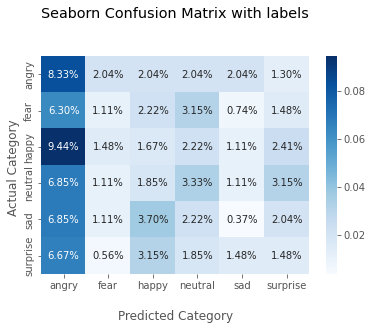

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Deblocare straturi

Se va schimba modelul EmotionVGG creat mai sus cu modelul ResNet50 pentru a testa pe un model preantrenat.

In plus, se va face fine-tuning cu un strat de 512 de neuroni. Spre deosebire de 3.4, se va modifica modelul cu cel ResNet50.

Se vor debloca straturile de la 143.

Rezultatele se salveaza in outputs/output34.



---

ANTRENARE

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os
import tensorflow
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output34'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output34/checkpoint1'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (224, 224), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (224, 224), batch_size = 128, class_mode = 'categorical')


# FOLOSIRE VGG16

## Loading VGG16 model

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False ## Not trainable weights

## Add last layers

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer = layers.Dropout(0.5)
prediction_layer = layers.Dense(6, activation='softmax')


model = models.Sequential([base_model, flatten_layer, dense_layer_1, dropout_layer, prediction_layer])

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.


In [ ]:
print("[INFO] base model status... \n")
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

print("\n\n[INFO] entire model status...\n")
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

[INFO] base model status... 

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_

In [ ]:
## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition34_1.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognitio34_1.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 20, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

[INFO] compiling model...
Epoch 1/20
 2/33 [>.............................] - ETA: 8:58 - loss: 3.8812 - accuracy: 0.1797 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 936s 28s/step - loss: 2.4417 - accuracy: 0.2035 - val_loss: 1.7203 - val_accuracy: 0.3027
Epoch 2/20
28/33 [========================>.....] - ETA: 9s - loss: 1.7192 - accuracy: 0.2795 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 93s 3s/step - loss: 1.7193 - accuracy: 0.2771 - val_loss: 1.6818 - val_accuracy: 0.3301
Epoch 3/20
23/33 [===================>..........] - ETA: 18s - loss: 1.7156 - accuracy: 0.2833

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 1.7110 - accuracy: 0.2909 - val_loss: 1.6704 - val_accuracy: 0.3203
Epoch 4/20


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 64s 2s/step - loss: 1.6907 - accuracy: 0.3043 - val_loss: 1.6474 - val_accuracy: 0.3242
Epoch 5/20
 2/33 [>.............................] - ETA: 1:00 - loss: 1.6584 - accuracy: 0.2891

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 91s 3s/step - loss: 1.6729 - accuracy: 0.3101 - val_loss: 1.6303 - val_accuracy: 0.3477
Epoch 6/20
13/33 [==========>...................] - ETA: 40s - loss: 1.6719 - accuracy: 0.3095

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 1.6662 - accuracy: 0.3113 - val_loss: 1.5989 - val_accuracy: 0.3438
Epoch 7/20
15/33 [============>.................] - ETA: 31s - loss: 1.6542 - accuracy: 0.3236

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 91s 3s/step - loss: 1.6515 - accuracy: 0.3220 - val_loss: 1.6005 - val_accuracy: 0.3613
Epoch 8/20
10/33 [========>.....................] - ETA: 47s - loss: 1.6414 - accuracy: 0.3180

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 67s 2s/step - loss: 1.6433 - accuracy: 0.3205 - val_loss: 1.5882 - val_accuracy: 0.3281
Epoch 9/20
12/33 [=========>....................] - ETA: 39s - loss: 1.6329 - accuracy: 0.3301

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.6173 - accuracy: 0.3344 - val_loss: 1.5853 - val_accuracy: 0.3457
Epoch 10/20
12/33 [=========>....................] - ETA: 39s - loss: 1.6395 - accuracy: 0.3105

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.6251 - accuracy: 0.3181 - val_loss: 1.5660 - val_accuracy: 0.3535
Epoch 11/20
 6/33 [====>.........................] - ETA: 51s - loss: 1.6095 - accuracy: 0.3307

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.6047 - accuracy: 0.3412 - val_loss: 1.5583 - val_accuracy: 0.3555
Epoch 12/20
 7/33 [=====>........................] - ETA: 49s - loss: 1.6245 - accuracy: 0.3270

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 64s 2s/step - loss: 1.6053 - accuracy: 0.3383 - val_loss: 1.5491 - val_accuracy: 0.3574
Epoch 13/20
 5/33 [===>..........................] - ETA: 53s - loss: 1.5652 - accuracy: 0.3625

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 92s 3s/step - loss: 1.5921 - accuracy: 0.3400 - val_loss: 1.5470 - val_accuracy: 0.3672
Epoch 14/20
29/33 [=========================>....] - ETA: 7s - loss: 1.6157 - accuracy: 0.3300

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 93s 3s/step - loss: 1.6107 - accuracy: 0.3315 - val_loss: 1.5272 - val_accuracy: 0.3730
Epoch 15/20
 2/33 [>.............................] - ETA: 1:00 - loss: 1.5527 - accuracy: 0.3516

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.5968 - accuracy: 0.3334 - val_loss: 1.5372 - val_accuracy: 0.3633
Epoch 16/20
14/33 [===========>..................] - ETA: 33s - loss: 1.5940 - accuracy: 0.3393

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 92s 3s/step - loss: 1.5812 - accuracy: 0.3490 - val_loss: 1.5065 - val_accuracy: 0.3906
Epoch 17/20
26/33 [======================>.......] - ETA: 13s - loss: 1.5819 - accuracy: 0.3380

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 92s 3s/step - loss: 1.5768 - accuracy: 0.3385 - val_loss: 1.5146 - val_accuracy: 0.3945
Epoch 18/20
33/33 [==============================] - ETA: 0s - loss: 1.5714 - accuracy: 0.3487

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 1.5714 - accuracy: 0.3487 - val_loss: 1.5156 - val_accuracy: 0.3633
Epoch 19/20
26/33 [======================>.......] - ETA: 12s - loss: 1.5606 - accuracy: 0.3557

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 64s 2s/step - loss: 1.5633 - accuracy: 0.3538 - val_loss: 1.5086 - val_accuracy: 0.3770
Epoch 20/20


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 64s 2s/step - loss: 1.5571 - accuracy: 0.3526 - val_loss: 1.5006 - val_accuracy: 0.3828




---

TESTARE

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output34/checkpoint1'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (224, 224), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("\n\n[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output34/checkpoint1...
4/4 [==============================] - 87s 28s/step - loss: 1.5545 - accuracy: 0.3750
              precision    recall  f1-score   support

           0       0.18      0.50      0.26        96
           1       0.18      0.14      0.15        81
           2       0.21      0.12      0.15        99
           3       0.23      0.22      0.23        94
           4       0.09      0.01      0.02        88
           5       0.16      0.10      0.12        82

    accuracy                           0.19       540
   macro avg       0.17      0.18      0.16       540
weighted avg       0.18      0.19      0.16       540



[INFO] accuracy: 37.50




---



---

ANTRENARE

In [ ]:
output = '/content/drive/MyDrive/GitHub/licenta/outputs/output34'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output34/checkpoint2'
start_epoch = 0

for layer in base_model.layers[143:]:
  layer.trainable = True

print("[INFO] base model status... \n")
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

print("\n\n[INFO] entire model status...\n\n")
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

[INFO] base model status... 

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_

In [ ]:
## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition34_2.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition34_2.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 100, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

[INFO] compiling model...
Epoch 1/100
26/33 [======================>.......] - ETA: 14s - loss: 2.1877 - accuracy: 0.2831

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 106s 3s/step - loss: 2.0646 - accuracy: 0.2948 - val_loss: 1.9183 - val_accuracy: 0.1797
Epoch 2/100
31/33 [===========================>..] - ETA: 4s - loss: 1.5568 - accuracy: 0.3669

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 73s 2s/step - loss: 1.5572 - accuracy: 0.3655 - val_loss: 1.8949 - val_accuracy: 0.1699
Epoch 3/100
 4/33 [==>...........................] - ETA: 59s - loss: 1.5202 - accuracy: 0.3652 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 72s 2s/step - loss: 1.5047 - accuracy: 0.3771 - val_loss: 1.9656 - val_accuracy: 0.1777
Epoch 4/100
32/33 [============================>.] - ETA: 1s - loss: 1.4586 - accuracy: 0.4118

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 94s 3s/step - loss: 1.4582 - accuracy: 0.4099 - val_loss: 2.0056 - val_accuracy: 0.2090
Epoch 5/100
12/33 [=========>....................] - ETA: 43s - loss: 1.4230 - accuracy: 0.4264

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 68s 2s/step - loss: 1.4338 - accuracy: 0.4160 - val_loss: 2.0794 - val_accuracy: 0.2051
Epoch 6/100
20/33 [=================>............] - ETA: 25s - loss: 1.3951 - accuracy: 0.4305

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 95s 3s/step - loss: 1.4085 - accuracy: 0.4209 - val_loss: 1.9606 - val_accuracy: 0.2188
Epoch 7/100
31/33 [===========================>..] - ETA: 3s - loss: 1.4029 - accuracy: 0.4205

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 1.4040 - accuracy: 0.4186 - val_loss: 2.1304 - val_accuracy: 0.2168
Epoch 8/100
16/33 [=============>................] - ETA: 32s - loss: 1.3457 - accuracy: 0.4409

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 64s 2s/step - loss: 1.3687 - accuracy: 0.4369 - val_loss: 1.9024 - val_accuracy: 0.2012
Epoch 9/100
15/33 [============>.................] - ETA: 31s - loss: 1.3553 - accuracy: 0.4399

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 92s 3s/step - loss: 1.3462 - accuracy: 0.4427 - val_loss: 1.7721 - val_accuracy: 0.2754
Epoch 10/100
18/33 [===============>..............] - ETA: 29s - loss: 1.3352 - accuracy: 0.4345

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.3292 - accuracy: 0.4463 - val_loss: 1.7565 - val_accuracy: 0.2734
Epoch 11/100
28/33 [========================>.....] - ETA: 9s - loss: 1.3047 - accuracy: 0.4699 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 90s 3s/step - loss: 1.3052 - accuracy: 0.4687 - val_loss: 1.5566 - val_accuracy: 0.2832
Epoch 12/100
 8/33 [======>.......................] - ETA: 51s - loss: 1.2501 - accuracy: 0.5068

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 93s 3s/step - loss: 1.3102 - accuracy: 0.4706 - val_loss: 1.5178 - val_accuracy: 0.3184
Epoch 13/100
20/33 [=================>............] - ETA: 25s - loss: 1.2825 - accuracy: 0.4695

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 91s 3s/step - loss: 1.2818 - accuracy: 0.4750 - val_loss: 1.3686 - val_accuracy: 0.4160
Epoch 14/100
11/33 [=========>....................] - ETA: 43s - loss: 1.2803 - accuracy: 0.4673

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 91s 3s/step - loss: 1.2614 - accuracy: 0.4755 - val_loss: 1.3131 - val_accuracy: 0.4766
Epoch 15/100
16/33 [=============>................] - ETA: 31s - loss: 1.2727 - accuracy: 0.4660

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 93s 3s/step - loss: 1.2668 - accuracy: 0.4752 - val_loss: 1.2743 - val_accuracy: 0.4883
Epoch 16/100
 6/33 [====>.........................] - ETA: 53s - loss: 1.2208 - accuracy: 0.4792

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.2341 - accuracy: 0.4891 - val_loss: 1.2297 - val_accuracy: 0.4824
Epoch 17/100
 8/33 [======>.......................] - ETA: 46s - loss: 1.2231 - accuracy: 0.4990

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 91s 3s/step - loss: 1.2405 - accuracy: 0.4806 - val_loss: 1.1603 - val_accuracy: 0.5156
Epoch 18/100
23/33 [===================>..........] - ETA: 18s - loss: 1.1994 - accuracy: 0.5053

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 63s 2s/step - loss: 1.2042 - accuracy: 0.5080 - val_loss: 1.1902 - val_accuracy: 0.4980
Epoch 19/100
23/33 [===================>..........] - ETA: 17s - loss: 1.1926 - accuracy: 0.5208

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 90s 3s/step - loss: 1.1909 - accuracy: 0.5151 - val_loss: 1.1823 - val_accuracy: 0.5332
Epoch 20/100
21/33 [==================>...........] - ETA: 22s - loss: 1.1853 - accuracy: 0.5119

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 64s 2s/step - loss: 1.1923 - accuracy: 0.5041 - val_loss: 1.2107 - val_accuracy: 0.5293
Epoch 21/100
 5/33 [===>..........................] - ETA: 52s - loss: 1.1849 - accuracy: 0.5188

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 63s 2s/step - loss: 1.1861 - accuracy: 0.5104 - val_loss: 1.1443 - val_accuracy: 0.5293
Epoch 22/100
20/33 [=================>............] - ETA: 24s - loss: 1.1295 - accuracy: 0.5391

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 63s 2s/step - loss: 1.1343 - accuracy: 0.5352 - val_loss: 1.1303 - val_accuracy: 0.5137
Epoch 23/100
 6/33 [====>.........................] - ETA: 51s - loss: 1.1579 - accuracy: 0.5182

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 64s 2s/step - loss: 1.1523 - accuracy: 0.5279 - val_loss: 1.1102 - val_accuracy: 0.5156
Epoch 24/100
14/33 [===========>..................] - ETA: 33s - loss: 1.1527 - accuracy: 0.5178

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 91s 3s/step - loss: 1.1688 - accuracy: 0.5214 - val_loss: 1.1282 - val_accuracy: 0.5352
Epoch 25/100
17/33 [==============>...............] - ETA: 30s - loss: 1.1586 - accuracy: 0.5386

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 94s 3s/step - loss: 1.1547 - accuracy: 0.5393 - val_loss: 1.1471 - val_accuracy: 0.5410
Epoch 26/100
13/33 [==========>...................] - ETA: 37s - loss: 1.1641 - accuracy: 0.5295

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 1.1436 - accuracy: 0.5255 - val_loss: 1.1222 - val_accuracy: 0.5410
Epoch 27/100
15/33 [============>.................] - ETA: 33s - loss: 1.1239 - accuracy: 0.5453

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 93s 3s/step - loss: 1.1288 - accuracy: 0.5469 - val_loss: 1.0951 - val_accuracy: 0.5605
Epoch 28/100
22/33 [===================>..........] - ETA: 20s - loss: 1.1366 - accuracy: 0.5443

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 1.1332 - accuracy: 0.5432 - val_loss: 1.1392 - val_accuracy: 0.5469
Epoch 29/100
14/33 [===========>..................] - ETA: 36s - loss: 1.0674 - accuracy: 0.5603

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.0851 - accuracy: 0.5522 - val_loss: 1.1919 - val_accuracy: 0.5352
Epoch 30/100
31/33 [===========================>..] - ETA: 3s - loss: 1.1116 - accuracy: 0.5438

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.1086 - accuracy: 0.5486 - val_loss: 1.1129 - val_accuracy: 0.5488
Epoch 31/100
26/33 [======================>.......] - ETA: 12s - loss: 1.1086 - accuracy: 0.5500

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 92s 3s/step - loss: 1.1038 - accuracy: 0.5503 - val_loss: 1.0914 - val_accuracy: 0.5645
Epoch 32/100
14/33 [===========>..................] - ETA: 35s - loss: 1.0503 - accuracy: 0.5795

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 94s 3s/step - loss: 1.0868 - accuracy: 0.5614 - val_loss: 1.1042 - val_accuracy: 0.5781
Epoch 33/100
17/33 [==============>...............] - ETA: 31s - loss: 1.0943 - accuracy: 0.5666

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 1.0913 - accuracy: 0.5651 - val_loss: 1.1039 - val_accuracy: 0.5684
Epoch 34/100
12/33 [=========>....................] - ETA: 36s - loss: 1.1102 - accuracy: 0.5657

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.0894 - accuracy: 0.5583 - val_loss: 1.1116 - val_accuracy: 0.5508
Epoch 35/100
11/33 [=========>....................] - ETA: 42s - loss: 1.1049 - accuracy: 0.5518

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 64s 2s/step - loss: 1.0736 - accuracy: 0.5658 - val_loss: 1.1472 - val_accuracy: 0.5547
Epoch 36/100
22/33 [===================>..........] - ETA: 20s - loss: 1.0646 - accuracy: 0.5539

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 93s 3s/step - loss: 1.0445 - accuracy: 0.5648 - val_loss: 1.0594 - val_accuracy: 0.5918
Epoch 37/100
25/33 [=====================>........] - ETA: 15s - loss: 1.0200 - accuracy: 0.5878

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 67s 2s/step - loss: 1.0317 - accuracy: 0.5833 - val_loss: 1.0963 - val_accuracy: 0.5586
Epoch 38/100
 3/33 [=>............................] - ETA: 57s - loss: 1.0770 - accuracy: 0.5495

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 92s 3s/step - loss: 1.0298 - accuracy: 0.5775 - val_loss: 1.0632 - val_accuracy: 0.6133
Epoch 39/100
33/33 [==============================] - ETA: 0s - loss: 1.0330 - accuracy: 0.5879

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 1.0330 - accuracy: 0.5879 - val_loss: 1.1013 - val_accuracy: 0.5781
Epoch 40/100
32/33 [============================>.] - ETA: 1s - loss: 1.0584 - accuracy: 0.5687

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.0585 - accuracy: 0.5690 - val_loss: 1.0906 - val_accuracy: 0.5586
Epoch 41/100
 4/33 [==>...........................] - ETA: 54s - loss: 1.0736 - accuracy: 0.5293

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.0396 - accuracy: 0.5789 - val_loss: 1.0994 - val_accuracy: 0.5840
Epoch 42/100
22/33 [===================>..........] - ETA: 20s - loss: 1.0421 - accuracy: 0.5845

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.0652 - accuracy: 0.5753 - val_loss: 1.0978 - val_accuracy: 0.5547
Epoch 43/100
 4/33 [==>...........................] - ETA: 55s - loss: 1.0726 - accuracy: 0.5898

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.0479 - accuracy: 0.5814 - val_loss: 1.0504 - val_accuracy: 0.5605
Epoch 44/100
26/33 [======================>.......] - ETA: 12s - loss: 1.0655 - accuracy: 0.5664

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.0633 - accuracy: 0.5663 - val_loss: 1.0773 - val_accuracy: 0.5605
Epoch 45/100
28/33 [========================>.....] - ETA: 9s - loss: 1.0299 - accuracy: 0.5857 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.0268 - accuracy: 0.5886 - val_loss: 1.0765 - val_accuracy: 0.5742
Epoch 46/100
29/33 [=========================>....] - ETA: 7s - loss: 1.0346 - accuracy: 0.5799

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.0340 - accuracy: 0.5782 - val_loss: 1.1005 - val_accuracy: 0.5430
Epoch 47/100
12/33 [=========>....................] - ETA: 40s - loss: 1.0668 - accuracy: 0.5729

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.0360 - accuracy: 0.5821 - val_loss: 1.0817 - val_accuracy: 0.5820
Epoch 48/100
22/33 [===================>..........] - ETA: 20s - loss: 1.0340 - accuracy: 0.5878

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 1.0260 - accuracy: 0.5913 - val_loss: 1.0586 - val_accuracy: 0.5723
Epoch 49/100
10/33 [========>.....................] - ETA: 45s - loss: 1.0120 - accuracy: 0.5906

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 67s 2s/step - loss: 1.0071 - accuracy: 0.5964 - val_loss: 1.0514 - val_accuracy: 0.5742
Epoch 50/100
18/33 [===============>..............] - ETA: 29s - loss: 0.9962 - accuracy: 0.5968

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 68s 2s/step - loss: 0.9785 - accuracy: 0.6018 - val_loss: 1.0611 - val_accuracy: 0.5625
Epoch 51/100
21/33 [==================>...........] - ETA: 22s - loss: 0.9764 - accuracy: 0.6146

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 67s 2s/step - loss: 0.9767 - accuracy: 0.6093 - val_loss: 1.0648 - val_accuracy: 0.6035
Epoch 52/100
13/33 [==========>...................] - ETA: 38s - loss: 0.9602 - accuracy: 0.6088

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 67s 2s/step - loss: 0.9802 - accuracy: 0.6059 - val_loss: 1.0524 - val_accuracy: 0.5879
Epoch 53/100
27/33 [=======================>......] - ETA: 11s - loss: 0.9765 - accuracy: 0.6015

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 67s 2s/step - loss: 0.9757 - accuracy: 0.5988 - val_loss: 1.0341 - val_accuracy: 0.5977
Epoch 54/100
30/33 [==========================>...] - ETA: 5s - loss: 0.9668 - accuracy: 0.6152

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 67s 2s/step - loss: 0.9648 - accuracy: 0.6158 - val_loss: 1.0810 - val_accuracy: 0.5605
Epoch 55/100
21/33 [==================>...........] - ETA: 22s - loss: 1.0070 - accuracy: 0.5995

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 67s 2s/step - loss: 0.9858 - accuracy: 0.6044 - val_loss: 1.0360 - val_accuracy: 0.5938
Epoch 56/100
33/33 [==============================] - ETA: 0s - loss: 0.9636 - accuracy: 0.6153

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 67s 2s/step - loss: 0.9636 - accuracy: 0.6153 - val_loss: 1.0570 - val_accuracy: 0.5977
Epoch 57/100
 5/33 [===>..........................] - ETA: 53s - loss: 1.0102 - accuracy: 0.5813

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.9659 - accuracy: 0.6139 - val_loss: 1.0730 - val_accuracy: 0.5957
Epoch 58/100
12/33 [=========>....................] - ETA: 39s - loss: 0.9200 - accuracy: 0.6237

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.9410 - accuracy: 0.6204 - val_loss: 1.0667 - val_accuracy: 0.5820
Epoch 59/100
25/33 [=====================>........] - ETA: 14s - loss: 0.9545 - accuracy: 0.6096

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.9648 - accuracy: 0.6076 - val_loss: 1.0196 - val_accuracy: 0.6074
Epoch 60/100
20/33 [=================>............] - ETA: 25s - loss: 0.9031 - accuracy: 0.6336

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.9107 - accuracy: 0.6331 - val_loss: 1.0717 - val_accuracy: 0.5996
Epoch 61/100
29/33 [=========================>....] - ETA: 7s - loss: 0.9413 - accuracy: 0.6298

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.9367 - accuracy: 0.6302 - val_loss: 1.0038 - val_accuracy: 0.5977
Epoch 62/100
13/33 [==========>...................] - ETA: 35s - loss: 0.9185 - accuracy: 0.6220

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.9197 - accuracy: 0.6229 - val_loss: 1.0431 - val_accuracy: 0.6074
Epoch 63/100
22/33 [===================>..........] - ETA: 21s - loss: 0.9253 - accuracy: 0.6303

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.9184 - accuracy: 0.6289 - val_loss: 1.0452 - val_accuracy: 0.5859
Epoch 64/100
33/33 [==============================] - ETA: 0s - loss: 0.9248 - accuracy: 0.6207

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.9248 - accuracy: 0.6207 - val_loss: 1.0970 - val_accuracy: 0.5957
Epoch 65/100
18/33 [===============>..............] - ETA: 27s - loss: 0.8916 - accuracy: 0.6442

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 0.8968 - accuracy: 0.6394 - val_loss: 1.0572 - val_accuracy: 0.6133
Epoch 66/100
13/33 [==========>...................] - ETA: 38s - loss: 0.9249 - accuracy: 0.6232

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 0.9196 - accuracy: 0.6268 - val_loss: 1.0536 - val_accuracy: 0.6016
Epoch 67/100
 7/33 [=====>........................] - ETA: 42s - loss: 0.8947 - accuracy: 0.6544

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.9011 - accuracy: 0.6372 - val_loss: 1.0689 - val_accuracy: 0.5820
Epoch 68/100
18/33 [===============>..............] - ETA: 27s - loss: 0.9180 - accuracy: 0.6383

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 0.9259 - accuracy: 0.6280 - val_loss: 1.0497 - val_accuracy: 0.5781
Epoch 69/100
26/33 [======================>.......] - ETA: 13s - loss: 0.8931 - accuracy: 0.6356

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 95s 3s/step - loss: 0.9016 - accuracy: 0.6350 - val_loss: 1.0130 - val_accuracy: 0.6172
Epoch 70/100
 8/33 [======>.......................] - ETA: 51s - loss: 0.8940 - accuracy: 0.6396

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 67s 2s/step - loss: 0.8801 - accuracy: 0.6486 - val_loss: 1.0590 - val_accuracy: 0.6172
Epoch 71/100
32/33 [============================>.] - ETA: 1s - loss: 0.8624 - accuracy: 0.6489

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 0.8608 - accuracy: 0.6491 - val_loss: 1.0999 - val_accuracy: 0.6152
Epoch 72/100
 5/33 [===>..........................] - ETA: 54s - loss: 0.8567 - accuracy: 0.6734

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.8719 - accuracy: 0.6591 - val_loss: 1.0076 - val_accuracy: 0.6016
Epoch 73/100
28/33 [========================>.....] - ETA: 9s - loss: 0.8703 - accuracy: 0.6616 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 94s 3s/step - loss: 0.8660 - accuracy: 0.6637 - val_loss: 1.0000 - val_accuracy: 0.6191
Epoch 74/100
 4/33 [==>...........................] - ETA: 59s - loss: 0.7692 - accuracy: 0.6758 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 67s 2s/step - loss: 0.8574 - accuracy: 0.6540 - val_loss: 1.0342 - val_accuracy: 0.6055
Epoch 75/100
16/33 [=============>................] - ETA: 30s - loss: 0.8970 - accuracy: 0.6498

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 93s 3s/step - loss: 0.8763 - accuracy: 0.6544 - val_loss: 1.0486 - val_accuracy: 0.6328
Epoch 76/100
20/33 [=================>............] - ETA: 25s - loss: 0.8695 - accuracy: 0.6551

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 67s 2s/step - loss: 0.8637 - accuracy: 0.6532 - val_loss: 1.0920 - val_accuracy: 0.6133
Epoch 77/100
21/33 [==================>...........] - ETA: 22s - loss: 0.8539 - accuracy: 0.6681

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.8398 - accuracy: 0.6688 - val_loss: 1.0515 - val_accuracy: 0.6191
Epoch 78/100
 3/33 [=>............................] - ETA: 55s - loss: 0.8034 - accuracy: 0.6771

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 0.8612 - accuracy: 0.6578 - val_loss: 1.0534 - val_accuracy: 0.6191
Epoch 79/100
27/33 [=======================>......] - ETA: 11s - loss: 0.8854 - accuracy: 0.6394

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.8809 - accuracy: 0.6430 - val_loss: 1.0379 - val_accuracy: 0.6289
Epoch 80/100
 8/33 [======>.......................] - ETA: 47s - loss: 0.8410 - accuracy: 0.6719

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.8715 - accuracy: 0.6508 - val_loss: 1.0903 - val_accuracy: 0.5957
Epoch 81/100
12/33 [=========>....................] - ETA: 39s - loss: 0.8482 - accuracy: 0.6458

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 0.8396 - accuracy: 0.6591 - val_loss: 1.0765 - val_accuracy: 0.6055
Epoch 82/100
23/33 [===================>..........] - ETA: 18s - loss: 0.8190 - accuracy: 0.6698

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.8165 - accuracy: 0.6748 - val_loss: 1.0590 - val_accuracy: 0.6016
Epoch 83/100
26/33 [======================>.......] - ETA: 12s - loss: 0.8465 - accuracy: 0.6570

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.8402 - accuracy: 0.6608 - val_loss: 1.0422 - val_accuracy: 0.6094
Epoch 84/100
29/33 [=========================>....] - ETA: 7s - loss: 0.8340 - accuracy: 0.6791

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.8387 - accuracy: 0.6782 - val_loss: 1.0450 - val_accuracy: 0.6113
Epoch 85/100
17/33 [==============>...............] - ETA: 28s - loss: 0.7994 - accuracy: 0.6696

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.8178 - accuracy: 0.6666 - val_loss: 1.0720 - val_accuracy: 0.6152
Epoch 86/100
 8/33 [======>.......................] - ETA: 48s - loss: 0.8277 - accuracy: 0.6543

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.8152 - accuracy: 0.6727 - val_loss: 1.0194 - val_accuracy: 0.6270
Epoch 87/100
 5/33 [===>..........................] - ETA: 53s - loss: 0.9022 - accuracy: 0.6648

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.8724 - accuracy: 0.6423 - val_loss: 1.0785 - val_accuracy: 0.6191
Epoch 88/100
23/33 [===================>..........] - ETA: 18s - loss: 0.8298 - accuracy: 0.6681

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.8349 - accuracy: 0.6666 - val_loss: 1.0405 - val_accuracy: 0.6016
Epoch 89/100
 5/33 [===>..........................] - ETA: 42s - loss: 0.8802 - accuracy: 0.6479

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.8245 - accuracy: 0.6663 - val_loss: 1.0477 - val_accuracy: 0.6211
Epoch 90/100
23/33 [===================>..........] - ETA: 18s - loss: 0.8201 - accuracy: 0.6790

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.8358 - accuracy: 0.6736 - val_loss: 1.0418 - val_accuracy: 0.6211
Epoch 91/100
33/33 [==============================] - ETA: 0s - loss: 0.7949 - accuracy: 0.6829

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GitHub/licenta/outputs/output34/checkpoint2/assets
33/33 [==============================] - 92s 3s/step - loss: 0.7949 - accuracy: 0.6829 - val_loss: 1.0506 - val_accuracy: 0.6348
Epoch 92/100
 3/33 [=>............................] - ETA: 57s - loss: 0.8062 - accuracy: 0.7005

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 67s 2s/step - loss: 0.8215 - accuracy: 0.6693 - val_loss: 1.0764 - val_accuracy: 0.6035
Epoch 93/100
31/33 [===========================>..] - ETA: 3s - loss: 0.8152 - accuracy: 0.6851

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.8171 - accuracy: 0.6819 - val_loss: 1.0490 - val_accuracy: 0.6348
Epoch 94/100
30/33 [==========================>...] - ETA: 5s - loss: 0.7923 - accuracy: 0.6826

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.7960 - accuracy: 0.6787 - val_loss: 1.0525 - val_accuracy: 0.6133
Epoch 95/100
28/33 [========================>.....] - ETA: 9s - loss: 0.7812 - accuracy: 0.6839 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 0.7823 - accuracy: 0.6877 - val_loss: 1.0525 - val_accuracy: 0.6152
Epoch 96/100
 2/33 [>.............................] - ETA: 1:00 - loss: 0.6646 - accuracy: 0.7383

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 65s 2s/step - loss: 0.8007 - accuracy: 0.6918 - val_loss: 1.0698 - val_accuracy: 0.5898
Epoch 97/100
10/33 [========>.....................] - ETA: 44s - loss: 0.8009 - accuracy: 0.6828

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 0.7831 - accuracy: 0.6855 - val_loss: 1.0576 - val_accuracy: 0.6191
Epoch 98/100
 2/33 [>.............................] - ETA: 1:04 - loss: 0.7207 - accuracy: 0.7344

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 67s 2s/step - loss: 0.7868 - accuracy: 0.6860 - val_loss: 1.0859 - val_accuracy: 0.6172
Epoch 99/100
23/33 [===================>..........] - ETA: 18s - loss: 0.7737 - accuracy: 0.6920

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 0.7829 - accuracy: 0.6904 - val_loss: 1.0324 - val_accuracy: 0.6230
Epoch 100/100
20/33 [=================>............] - ETA: 24s - loss: 0.7588 - accuracy: 0.6960

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 66s 2s/step - loss: 0.7446 - accuracy: 0.6945 - val_loss: 1.0864 - val_accuracy: 0.6055




---

TESTARE

In [ ]:
model = '/content/drive/MyDrive/GitHub/licenta/outputs/output34/checkpoint2'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (224, 224), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("\n\n[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output34/checkpoint2...
4/4 [==============================] - 4s 687ms/step - loss: 1.0311 - accuracy: 0.5996
              precision    recall  f1-score   support

           0       0.21      0.31      0.25        96
           1       0.14      0.10      0.12        81
           2       0.25      0.23      0.24        99
           3       0.25      0.24      0.25        94
           4       0.18      0.15      0.16        88
           5       0.18      0.18      0.18        82

    accuracy                           0.21       540
   macro avg       0.20      0.20      0.20       540
weighted avg       0.20      0.21      0.20       540



[INFO] accuracy: 59.96


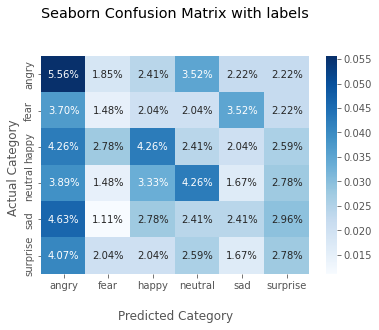

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Deblocare straturi si modificare learning rate

Se va schimba modelul EmotionVGG creat mai sus cu modelul ResNet50 pentru a testa pe un model preantrenat.

In plus, se va face fine-tuning cu un strat de 512 de neuroni. Spre deosebire de 3.4, se va modifica modelul cu cel ResNet50.

Se vor debloca straturile de la 143 si se va modifica learning rate-ul la 10^-3.

Rezultatele se salveaza in outputs/output35.



---

ANTRENARE

In [5]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os
import tensorflow
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output35'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output35/checkpoint1'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (224, 224), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (224, 224), batch_size = 128, class_mode = 'categorical')


# FOLOSIRE VGG16

## Loading VGG16 model

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False ## Not trainable weights

## Add last layers

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer = layers.Dropout(0.5)
prediction_layer = layers.Dense(6, activation='softmax')


model = models.Sequential([base_model, flatten_layer, dense_layer_1, dropout_layer, prediction_layer])

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.


In [6]:
print("[INFO] base model status... \n")
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

print("\n\n[INFO] entire model status...\n")
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

[INFO] base model status... 

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_

In [7]:
## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition35_1.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognitio35_1.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 20, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

[INFO] compiling model...
Epoch 1/20
19/33 [================>.............] - ETA: 21s - loss: 13.2071 - accuracy: 0.1840

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 85s 2s/step - loss: 8.3465 - accuracy: 0.1826 - val_loss: 1.7475 - val_accuracy: 0.1875
Epoch 2/20
31/33 [===========================>..] - ETA: 3s - loss: 1.7741 - accuracy: 0.1932

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 79s 2s/step - loss: 1.7733 - accuracy: 0.1914 - val_loss: 1.7521 - val_accuracy: 0.3359
Epoch 3/20
27/33 [=======================>......] - ETA: 10s - loss: 1.7476 - accuracy: 0.1982

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 61s 2s/step - loss: 1.7425 - accuracy: 0.2005 - val_loss: 1.6984 - val_accuracy: 0.3066
Epoch 4/20
 1/33 [..............................] - ETA: 1:09 - loss: 1.7289 - accuracy: 0.2031

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 60s 2s/step - loss: 1.7485 - accuracy: 0.2210 - val_loss: 1.6963 - val_accuracy: 0.1914
Epoch 5/20
 1/33 [..............................] - ETA: 1:10 - loss: 1.7733 - accuracy: 0.1797

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 59s 2s/step - loss: 1.7377 - accuracy: 0.2297 - val_loss: 1.6617 - val_accuracy: 0.2891
Epoch 6/20
23/33 [===================>..........] - ETA: 16s - loss: 1.7643 - accuracy: 0.2287

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.7652 - accuracy: 0.2258 - val_loss: 1.6543 - val_accuracy: 0.3125
Epoch 7/20
 7/33 [=====>........................] - ETA: 43s - loss: 1.7094 - accuracy: 0.2556

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.7328 - accuracy: 0.2251 - val_loss: 1.6522 - val_accuracy: 0.2930
Epoch 8/20
29/33 [=========================>....] - ETA: 6s - loss: 1.7199 - accuracy: 0.2316

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.7212 - accuracy: 0.2302 - val_loss: 1.6610 - val_accuracy: 0.3008
Epoch 9/20
23/33 [===================>..........] - ETA: 16s - loss: 1.7481 - accuracy: 0.2327

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.7424 - accuracy: 0.2271 - val_loss: 1.6520 - val_accuracy: 0.2969
Epoch 10/20
 9/33 [=======>......................] - ETA: 35s - loss: 1.7092 - accuracy: 0.2342

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.7140 - accuracy: 0.2346 - val_loss: 1.6505 - val_accuracy: 0.3223
Epoch 11/20
12/33 [=========>....................] - ETA: 35s - loss: 1.7126 - accuracy: 0.2298

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 80s 2s/step - loss: 1.7035 - accuracy: 0.2476 - val_loss: 1.6530 - val_accuracy: 0.3535
Epoch 12/20
16/33 [=============>................] - ETA: 27s - loss: 1.6934 - accuracy: 0.2472

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.7121 - accuracy: 0.2365 - val_loss: 1.6293 - val_accuracy: 0.3027
Epoch 13/20
 1/33 [..............................] - ETA: 1:03 - loss: 1.7123 - accuracy: 0.2266

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7076 - accuracy: 0.2404 - val_loss: 1.6586 - val_accuracy: 0.2969
Epoch 14/20
25/33 [=====================>........] - ETA: 12s - loss: 1.7227 - accuracy: 0.2288

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7193 - accuracy: 0.2319 - val_loss: 1.6389 - val_accuracy: 0.3047
Epoch 15/20
29/33 [=========================>....] - ETA: 6s - loss: 1.6989 - accuracy: 0.2366

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7036 - accuracy: 0.2346 - val_loss: 1.6432 - val_accuracy: 0.2812
Epoch 16/20
31/33 [===========================>..] - ETA: 3s - loss: 1.6934 - accuracy: 0.2613

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6940 - accuracy: 0.2591 - val_loss: 1.6235 - val_accuracy: 0.2930
Epoch 17/20
 1/33 [..............................] - ETA: 1:03 - loss: 1.7729 - accuracy: 0.2500

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7043 - accuracy: 0.2450 - val_loss: 1.6364 - val_accuracy: 0.2715
Epoch 18/20
28/33 [========================>.....] - ETA: 8s - loss: 1.7014 - accuracy: 0.2438

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7042 - accuracy: 0.2431 - val_loss: 1.6118 - val_accuracy: 0.3125
Epoch 19/20
15/33 [============>.................] - ETA: 28s - loss: 1.6845 - accuracy: 0.2464

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6907 - accuracy: 0.2407 - val_loss: 1.6227 - val_accuracy: 0.3105
Epoch 20/20
18/33 [===============>..............] - ETA: 24s - loss: 1.7557 - accuracy: 0.2500

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7262 - accuracy: 0.2572 - val_loss: 1.5911 - val_accuracy: 0.3164




---

TESTARE

In [8]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output35/checkpoint1'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (224, 224), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("\n\n[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output35/checkpoint1...
4/4 [==============================] - 4s 589ms/step - loss: 1.6804 - accuracy: 0.3301
              precision    recall  f1-score   support

           0       0.16      0.49      0.24        96
           1       0.16      0.09      0.11        81
           2       0.13      0.04      0.06        99
           3       0.17      0.19      0.18        94
           4       0.21      0.15      0.17        88
           5       0.00      0.00      0.00        82

    accuracy                           0.16       540
   macro avg       0.14      0.16      0.13       540
weighted avg       0.14      0.16      0.13       540



[INFO] accuracy: 33.01


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




---



---

ANTRENARE

In [9]:
output = '/content/drive/MyDrive/GitHub/licenta/outputs/output35'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output35/checkpoint2'
start_epoch = 0

for layer in base_model.layers[143:]:
  layer.trainable = True

print("[INFO] base model status... \n")
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

print("\n\n[INFO] entire model status...\n\n")
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

[INFO] base model status... 

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_

In [10]:
## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition35_2.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition35_2.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 100, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

[INFO] compiling model...
Epoch 1/100
 5/33 [===>..........................] - ETA: 45s - loss: 1.8419 - accuracy: 0.1937

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 84s 2s/step - loss: 1.7954 - accuracy: 0.1884 - val_loss: 1.7443 - val_accuracy: 0.2012
Epoch 2/100
 2/33 [>.............................] - ETA: 48s - loss: 1.7618 - accuracy: 0.1875 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 80s 2s/step - loss: 1.7422 - accuracy: 0.2173 - val_loss: 1.6349 - val_accuracy: 0.3008
Epoch 3/100
15/33 [============>.................] - ETA: 31s - loss: 1.7110 - accuracy: 0.2271

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.7110 - accuracy: 0.2356 - val_loss: 1.6554 - val_accuracy: 0.2871
Epoch 4/100
20/33 [=================>............] - ETA: 20s - loss: 1.7092 - accuracy: 0.2319

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7129 - accuracy: 0.2351 - val_loss: 1.6221 - val_accuracy: 0.2969
Epoch 5/100
12/33 [=========>....................] - ETA: 34s - loss: 1.7325 - accuracy: 0.2135

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7347 - accuracy: 0.2205 - val_loss: 1.6764 - val_accuracy: 0.2520
Epoch 6/100
27/33 [=======================>......] - ETA: 9s - loss: 1.7036 - accuracy: 0.2338 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.7062 - accuracy: 0.2367 - val_loss: 1.6536 - val_accuracy: 0.2871
Epoch 7/100
29/33 [=========================>....] - ETA: 6s - loss: 1.7077 - accuracy: 0.2335

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 80s 2s/step - loss: 1.7071 - accuracy: 0.2348 - val_loss: 1.6276 - val_accuracy: 0.3105
Epoch 8/100
26/33 [======================>.......] - ETA: 11s - loss: 1.7221 - accuracy: 0.2427

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.7230 - accuracy: 0.2380 - val_loss: 1.6265 - val_accuracy: 0.2910
Epoch 9/100
19/33 [================>.............] - ETA: 22s - loss: 1.6899 - accuracy: 0.2511

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7169 - accuracy: 0.2402 - val_loss: 1.6507 - val_accuracy: 0.2773
Epoch 10/100
30/33 [==========================>...] - ETA: 4s - loss: 1.7036 - accuracy: 0.2367

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 80s 2s/step - loss: 1.7028 - accuracy: 0.2358 - val_loss: 1.5997 - val_accuracy: 0.3145
Epoch 11/100
 8/33 [======>.......................] - ETA: 40s - loss: 1.7016 - accuracy: 0.2124

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.6958 - accuracy: 0.2404 - val_loss: 1.6016 - val_accuracy: 0.3145
Epoch 12/100
 9/33 [=======>......................] - ETA: 36s - loss: 1.7148 - accuracy: 0.2495

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7237 - accuracy: 0.2411 - val_loss: 1.6007 - val_accuracy: 0.2891
Epoch 13/100
28/33 [========================>.....] - ETA: 8s - loss: 1.7001 - accuracy: 0.2358

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7055 - accuracy: 0.2314 - val_loss: 1.6529 - val_accuracy: 0.2734
Epoch 14/100
16/33 [=============>................] - ETA: 26s - loss: 1.6999 - accuracy: 0.2508

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7018 - accuracy: 0.2368 - val_loss: 1.5949 - val_accuracy: 0.3066
Epoch 15/100
15/33 [============>.................] - ETA: 29s - loss: 1.6965 - accuracy: 0.2375

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7182 - accuracy: 0.2317 - val_loss: 1.6133 - val_accuracy: 0.2871
Epoch 16/100
25/33 [=====================>........] - ETA: 12s - loss: 1.7037 - accuracy: 0.2343

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7037 - accuracy: 0.2341 - val_loss: 1.5961 - val_accuracy: 0.2812
Epoch 17/100
29/33 [=========================>....] - ETA: 6s - loss: 1.7013 - accuracy: 0.2349

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6984 - accuracy: 0.2375 - val_loss: 1.6343 - val_accuracy: 0.2695
Epoch 18/100
 6/33 [====>.........................] - ETA: 38s - loss: 1.6699 - accuracy: 0.2492

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6946 - accuracy: 0.2363 - val_loss: 1.5992 - val_accuracy: 0.3008
Epoch 19/100
12/33 [=========>....................] - ETA: 34s - loss: 1.6869 - accuracy: 0.2480

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6893 - accuracy: 0.2419 - val_loss: 1.6197 - val_accuracy: 0.2910
Epoch 20/100
 2/33 [>.............................] - ETA: 50s - loss: 1.7076 - accuracy: 0.2266 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6916 - accuracy: 0.2419 - val_loss: 1.6004 - val_accuracy: 0.2969
Epoch 21/100
14/33 [===========>..................] - ETA: 31s - loss: 1.6779 - accuracy: 0.2600

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6841 - accuracy: 0.2499 - val_loss: 1.6004 - val_accuracy: 0.2988
Epoch 22/100
32/33 [============================>.] - ETA: 1s - loss: 1.6860 - accuracy: 0.2459

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6874 - accuracy: 0.2460 - val_loss: 1.6130 - val_accuracy: 0.2988
Epoch 23/100
11/33 [=========>....................] - ETA: 36s - loss: 1.7072 - accuracy: 0.2216

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7001 - accuracy: 0.2409 - val_loss: 1.6240 - val_accuracy: 0.2734
Epoch 24/100


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7011 - accuracy: 0.2334 - val_loss: 1.6327 - val_accuracy: 0.2773
Epoch 25/100
17/33 [==============>...............] - ETA: 25s - loss: 1.6843 - accuracy: 0.2406

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6935 - accuracy: 0.2377 - val_loss: 1.6007 - val_accuracy: 0.2969
Epoch 26/100


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7060 - accuracy: 0.2358 - val_loss: 1.6091 - val_accuracy: 0.2812
Epoch 27/100
13/33 [==========>...................] - ETA: 33s - loss: 1.7034 - accuracy: 0.2248

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7017 - accuracy: 0.2377 - val_loss: 1.5960 - val_accuracy: 0.2812
Epoch 28/100
11/33 [=========>....................] - ETA: 33s - loss: 1.6751 - accuracy: 0.2542

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6915 - accuracy: 0.2416 - val_loss: 1.5893 - val_accuracy: 0.2891
Epoch 29/100
24/33 [====================>.........] - ETA: 14s - loss: 1.6913 - accuracy: 0.2529

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 59s 2s/step - loss: 1.6997 - accuracy: 0.2396 - val_loss: 1.5847 - val_accuracy: 0.3086
Epoch 30/100
 8/33 [======>.......................] - ETA: 41s - loss: 1.7371 - accuracy: 0.2246

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7272 - accuracy: 0.2251 - val_loss: 1.5856 - val_accuracy: 0.3086
Epoch 31/100
25/33 [=====================>........] - ETA: 12s - loss: 1.6908 - accuracy: 0.2359

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6887 - accuracy: 0.2370 - val_loss: 1.6066 - val_accuracy: 0.2832
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 1.6915 - accuracy: 0.2419

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.6915 - accuracy: 0.2419 - val_loss: 1.5826 - val_accuracy: 0.3027
Epoch 33/100
18/33 [===============>..............] - ETA: 23s - loss: 1.6871 - accuracy: 0.2379

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6921 - accuracy: 0.2409 - val_loss: 1.6013 - val_accuracy: 0.2910
Epoch 34/100
 2/33 [>.............................] - ETA: 50s - loss: 1.6828 - accuracy: 0.2461 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.6874 - accuracy: 0.2436 - val_loss: 1.5699 - val_accuracy: 0.2988
Epoch 35/100
10/33 [========>.....................] - ETA: 34s - loss: 1.6825 - accuracy: 0.2530

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6803 - accuracy: 0.2484 - val_loss: 1.6137 - val_accuracy: 0.2832
Epoch 36/100
18/33 [===============>..............] - ETA: 25s - loss: 1.6982 - accuracy: 0.2365

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6987 - accuracy: 0.2370 - val_loss: 1.5743 - val_accuracy: 0.2910
Epoch 37/100
25/33 [=====================>........] - ETA: 13s - loss: 1.6830 - accuracy: 0.2516

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.6892 - accuracy: 0.2428 - val_loss: 1.5745 - val_accuracy: 0.2910
Epoch 38/100
32/33 [============================>.] - ETA: 1s - loss: 1.7021 - accuracy: 0.2323

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7006 - accuracy: 0.2339 - val_loss: 1.5818 - val_accuracy: 0.2969
Epoch 39/100
30/33 [==========================>...] - ETA: 4s - loss: 1.6860 - accuracy: 0.2410

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6847 - accuracy: 0.2436 - val_loss: 1.6134 - val_accuracy: 0.2852
Epoch 40/100
11/33 [=========>....................] - ETA: 37s - loss: 1.7005 - accuracy: 0.2422

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6935 - accuracy: 0.2390 - val_loss: 1.5889 - val_accuracy: 0.3008
Epoch 41/100
10/33 [========>.....................] - ETA: 38s - loss: 1.6647 - accuracy: 0.2594

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6806 - accuracy: 0.2455 - val_loss: 1.5953 - val_accuracy: 0.2910
Epoch 42/100
24/33 [====================>.........] - ETA: 14s - loss: 1.6895 - accuracy: 0.2374

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6874 - accuracy: 0.2397 - val_loss: 1.6107 - val_accuracy: 0.2754
Epoch 43/100
21/33 [==================>...........] - ETA: 18s - loss: 1.6745 - accuracy: 0.2432

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6764 - accuracy: 0.2436 - val_loss: 1.5731 - val_accuracy: 0.2871
Epoch 44/100
 9/33 [=======>......................] - ETA: 39s - loss: 1.7106 - accuracy: 0.2257

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7133 - accuracy: 0.2288 - val_loss: 1.5624 - val_accuracy: 0.3066
Epoch 45/100
16/33 [=============>................] - ETA: 27s - loss: 1.6768 - accuracy: 0.2373

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6835 - accuracy: 0.2387 - val_loss: 1.5784 - val_accuracy: 0.3047
Epoch 46/100
10/33 [========>.....................] - ETA: 35s - loss: 1.7065 - accuracy: 0.2249

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6997 - accuracy: 0.2356 - val_loss: 1.5819 - val_accuracy: 0.2949
Epoch 47/100
 1/33 [..............................] - ETA: 1:04 - loss: 1.6706 - accuracy: 0.2109

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 78s 2s/step - loss: 1.6725 - accuracy: 0.2445 - val_loss: 1.5724 - val_accuracy: 0.3203
Epoch 48/100
21/33 [==================>...........] - ETA: 20s - loss: 1.6776 - accuracy: 0.2433

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6842 - accuracy: 0.2387 - val_loss: 1.5815 - val_accuracy: 0.2871
Epoch 49/100
 8/33 [======>.......................] - ETA: 42s - loss: 1.6911 - accuracy: 0.2432

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.6850 - accuracy: 0.2431 - val_loss: 1.6068 - val_accuracy: 0.2852
Epoch 50/100
31/33 [===========================>..] - ETA: 3s - loss: 1.6843 - accuracy: 0.2374

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6851 - accuracy: 0.2380 - val_loss: 1.5621 - val_accuracy: 0.3086
Epoch 51/100


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6905 - accuracy: 0.2385 - val_loss: 1.5699 - val_accuracy: 0.3125
Epoch 52/100
25/33 [=====================>........] - ETA: 12s - loss: 1.6772 - accuracy: 0.2411

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6829 - accuracy: 0.2402 - val_loss: 1.5828 - val_accuracy: 0.2910
Epoch 53/100
 9/33 [=======>......................] - ETA: 39s - loss: 1.6883 - accuracy: 0.2483

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6878 - accuracy: 0.2419 - val_loss: 1.5733 - val_accuracy: 0.2930
Epoch 54/100
 2/33 [>.............................] - ETA: 48s - loss: 1.6927 - accuracy: 0.2656 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6833 - accuracy: 0.2421 - val_loss: 1.5658 - val_accuracy: 0.3047
Epoch 55/100


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6836 - accuracy: 0.2448 - val_loss: 1.5938 - val_accuracy: 0.3008
Epoch 56/100
16/33 [=============>................] - ETA: 28s - loss: 1.6841 - accuracy: 0.2354

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6815 - accuracy: 0.2414 - val_loss: 1.5718 - val_accuracy: 0.3125
Epoch 57/100
19/33 [================>.............] - ETA: 22s - loss: 1.6962 - accuracy: 0.2304

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6921 - accuracy: 0.2363 - val_loss: 1.5739 - val_accuracy: 0.3066
Epoch 58/100
25/33 [=====================>........] - ETA: 13s - loss: 1.6928 - accuracy: 0.2346

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.6904 - accuracy: 0.2319 - val_loss: 1.5824 - val_accuracy: 0.2988
Epoch 59/100
14/33 [===========>..................] - ETA: 29s - loss: 1.6712 - accuracy: 0.2485

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.7009 - accuracy: 0.2307 - val_loss: 1.5634 - val_accuracy: 0.2930
Epoch 60/100
 2/33 [>.............................] - ETA: 50s - loss: 1.6455 - accuracy: 0.2656 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7058 - accuracy: 0.2326 - val_loss: 1.5607 - val_accuracy: 0.3125
Epoch 61/100
32/33 [============================>.] - ETA: 1s - loss: 1.7051 - accuracy: 0.2303

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.7028 - accuracy: 0.2307 - val_loss: 1.5642 - val_accuracy: 0.3008
Epoch 62/100
 5/33 [===>..........................] - ETA: 45s - loss: 1.6693 - accuracy: 0.2438

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6808 - accuracy: 0.2428 - val_loss: 1.6036 - val_accuracy: 0.2754
Epoch 63/100
 9/33 [=======>......................] - ETA: 36s - loss: 1.7002 - accuracy: 0.2495

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6775 - accuracy: 0.2416 - val_loss: 1.5646 - val_accuracy: 0.3105
Epoch 64/100
19/33 [================>.............] - ETA: 22s - loss: 1.6844 - accuracy: 0.2403

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6759 - accuracy: 0.2458 - val_loss: 1.5797 - val_accuracy: 0.3086
Epoch 65/100
10/33 [========>.....................] - ETA: 37s - loss: 1.6815 - accuracy: 0.2430

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6877 - accuracy: 0.2404 - val_loss: 1.5648 - val_accuracy: 0.2988
Epoch 66/100
19/33 [================>.............] - ETA: 23s - loss: 1.6925 - accuracy: 0.2422

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6882 - accuracy: 0.2433 - val_loss: 1.5760 - val_accuracy: 0.2910
Epoch 67/100
24/33 [====================>.........] - ETA: 14s - loss: 1.6797 - accuracy: 0.2374

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6773 - accuracy: 0.2445 - val_loss: 1.5540 - val_accuracy: 0.3047
Epoch 68/100
 5/33 [===>..........................] - ETA: 45s - loss: 1.6936 - accuracy: 0.2531

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.6837 - accuracy: 0.2402 - val_loss: 1.5727 - val_accuracy: 0.2969
Epoch 69/100
29/33 [=========================>....] - ETA: 6s - loss: 1.6780 - accuracy: 0.2471

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6772 - accuracy: 0.2455 - val_loss: 1.6008 - val_accuracy: 0.2871
Epoch 70/100
26/33 [======================>.......] - ETA: 11s - loss: 1.6676 - accuracy: 0.2521

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6711 - accuracy: 0.2460 - val_loss: 1.6027 - val_accuracy: 0.2949
Epoch 71/100
 2/33 [>.............................] - ETA: 47s - loss: 1.6958 - accuracy: 0.2383 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.6838 - accuracy: 0.2385 - val_loss: 1.5549 - val_accuracy: 0.3086
Epoch 72/100
 9/33 [=======>......................] - ETA: 40s - loss: 1.6819 - accuracy: 0.2352

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6713 - accuracy: 0.2375 - val_loss: 1.5748 - val_accuracy: 0.2988
Epoch 73/100
16/33 [=============>................] - ETA: 27s - loss: 1.6833 - accuracy: 0.2476

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6751 - accuracy: 0.2433 - val_loss: 1.5722 - val_accuracy: 0.3047
Epoch 74/100
 1/33 [..............................] - ETA: 1:02 - loss: 1.6196 - accuracy: 0.2656

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6788 - accuracy: 0.2387 - val_loss: 1.5694 - val_accuracy: 0.2617
Epoch 75/100
19/33 [================>.............] - ETA: 23s - loss: 1.7124 - accuracy: 0.2278

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.7039 - accuracy: 0.2351 - val_loss: 1.5684 - val_accuracy: 0.2910
Epoch 76/100
16/33 [=============>................] - ETA: 27s - loss: 1.6948 - accuracy: 0.2295

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6993 - accuracy: 0.2271 - val_loss: 1.5620 - val_accuracy: 0.3027
Epoch 77/100
 2/33 [>.............................] - ETA: 54s - loss: 1.6686 - accuracy: 0.2695 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6672 - accuracy: 0.2450 - val_loss: 1.5927 - val_accuracy: 0.2871
Epoch 78/100
 2/33 [>.............................] - ETA: 52s - loss: 1.7187 - accuracy: 0.2617 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6753 - accuracy: 0.2450 - val_loss: 1.5941 - val_accuracy: 0.2773
Epoch 79/100
 6/33 [====>.........................] - ETA: 44s - loss: 1.6873 - accuracy: 0.2253

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6702 - accuracy: 0.2426 - val_loss: 1.5582 - val_accuracy: 0.3008
Epoch 80/100


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6664 - accuracy: 0.2477 - val_loss: 1.5641 - val_accuracy: 0.2891
Epoch 81/100
18/33 [===============>..............] - ETA: 24s - loss: 1.6696 - accuracy: 0.2400

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6747 - accuracy: 0.2450 - val_loss: 1.6105 - val_accuracy: 0.2793
Epoch 82/100
 4/33 [==>...........................] - ETA: 47s - loss: 1.6500 - accuracy: 0.2441

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6862 - accuracy: 0.2377 - val_loss: 1.5583 - val_accuracy: 0.3008
Epoch 83/100
21/33 [==================>...........] - ETA: 19s - loss: 1.7005 - accuracy: 0.2219

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6898 - accuracy: 0.2380 - val_loss: 1.5748 - val_accuracy: 0.3047
Epoch 84/100
27/33 [=======================>......] - ETA: 9s - loss: 1.6756 - accuracy: 0.2421 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6750 - accuracy: 0.2419 - val_loss: 1.5829 - val_accuracy: 0.2871
Epoch 85/100
 4/33 [==>...........................] - ETA: 47s - loss: 1.7064 - accuracy: 0.2383

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6809 - accuracy: 0.2365 - val_loss: 1.5581 - val_accuracy: 0.2949
Epoch 86/100
11/33 [=========>....................] - ETA: 33s - loss: 1.6683 - accuracy: 0.2343

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6814 - accuracy: 0.2385 - val_loss: 1.5756 - val_accuracy: 0.2988
Epoch 87/100
 3/33 [=>............................] - ETA: 50s - loss: 1.7028 - accuracy: 0.1901

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6717 - accuracy: 0.2431 - val_loss: 1.5714 - val_accuracy: 0.3047
Epoch 88/100
 8/33 [======>.......................] - ETA: 41s - loss: 1.6928 - accuracy: 0.2373

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6741 - accuracy: 0.2484 - val_loss: 1.5579 - val_accuracy: 0.3008
Epoch 89/100
 7/33 [=====>........................] - ETA: 36s - loss: 1.7055 - accuracy: 0.2430

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.7014 - accuracy: 0.2309 - val_loss: 1.5530 - val_accuracy: 0.2949
Epoch 90/100
32/33 [============================>.] - ETA: 1s - loss: 1.6925 - accuracy: 0.2343

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6909 - accuracy: 0.2351 - val_loss: 1.5965 - val_accuracy: 0.2832
Epoch 91/100
 6/33 [====>.........................] - ETA: 43s - loss: 1.6924 - accuracy: 0.2279

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6940 - accuracy: 0.2348 - val_loss: 1.5759 - val_accuracy: 0.2949
Epoch 92/100
 7/33 [=====>........................] - ETA: 42s - loss: 1.6648 - accuracy: 0.2589

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6747 - accuracy: 0.2431 - val_loss: 1.5578 - val_accuracy: 0.3203
Epoch 93/100
28/33 [========================>.....] - ETA: 8s - loss: 1.6765 - accuracy: 0.2421

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6758 - accuracy: 0.2426 - val_loss: 1.5723 - val_accuracy: 0.3027
Epoch 94/100
 4/33 [==>...........................] - ETA: 46s - loss: 1.6705 - accuracy: 0.2559

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6680 - accuracy: 0.2377 - val_loss: 1.5953 - val_accuracy: 0.2793
Epoch 95/100
13/33 [==========>...................] - ETA: 30s - loss: 1.6900 - accuracy: 0.2471

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6861 - accuracy: 0.2414 - val_loss: 1.5966 - val_accuracy: 0.2832
Epoch 96/100


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6723 - accuracy: 0.2411 - val_loss: 1.5662 - val_accuracy: 0.3086
Epoch 97/100
 6/33 [====>.........................] - ETA: 43s - loss: 1.6765 - accuracy: 0.2539

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6882 - accuracy: 0.2385 - val_loss: 1.5792 - val_accuracy: 0.2988
Epoch 98/100
27/33 [=======================>......] - ETA: 9s - loss: 1.6868 - accuracy: 0.2496 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6840 - accuracy: 0.2487 - val_loss: 1.5714 - val_accuracy: 0.3145
Epoch 99/100
29/33 [=========================>....] - ETA: 6s - loss: 1.6658 - accuracy: 0.2449

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6673 - accuracy: 0.2470 - val_loss: 1.5756 - val_accuracy: 0.3145
Epoch 100/100
26/33 [======================>.......] - ETA: 11s - loss: 1.6748 - accuracy: 0.2418

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6729 - accuracy: 0.2414 - val_loss: 1.5581 - val_accuracy: 0.2969




---

TESTARE

In [11]:
model = '/content/drive/MyDrive/GitHub/licenta/outputs/output35/checkpoint2'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (224, 224), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("\n\n[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output35/checkpoint2...
4/4 [==============================] - 4s 541ms/step - loss: 1.6082 - accuracy: 0.2852
              precision    recall  f1-score   support

           0       0.17      0.72      0.27        96
           1       0.00      0.00      0.00        81
           2       0.12      0.07      0.09        99
           3       0.22      0.17      0.19        94
           4       0.00      0.00      0.00        88
           5       0.00      0.00      0.00        82

    accuracy                           0.17       540
   macro avg       0.08      0.16      0.09       540
weighted avg       0.09      0.17      0.10       540



[INFO] accuracy: 28.52


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


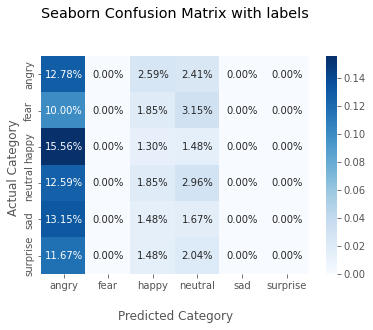

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Deblocare straturi si modificare learning rate 2

Se va schimba modelul EmotionVGG creat mai sus cu modelul ResNet50 pentru a testa pe un model preantrenat.

In plus, se va face fine-tuning cu un strat de 512 de neuroni. Spre deosebire de 3.4, se va modifica modelul cu cel ResNet50.

Se vor debloca straturile de la 143 si modificare learning la 10^-5.

Rezultatele se salveaza in outputs/output36.



---

ANTRENARE

In [13]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os
import tensorflow
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output36'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output36/checkpoint1'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (224, 224), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (224, 224), batch_size = 128, class_mode = 'categorical')


# FOLOSIRE VGG16

## Loading VGG16 model

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False ## Not trainable weights

## Add last layers

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer = layers.Dropout(0.5)
prediction_layer = layers.Dense(6, activation='softmax')


model = models.Sequential([base_model, flatten_layer, dense_layer_1, dropout_layer, prediction_layer])

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.


In [14]:
print("[INFO] base model status... \n")
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

print("\n\n[INFO] entire model status...\n")
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

[INFO] base model status... 

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_

In [15]:
## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition36_1.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognitio36_1.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 20, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

[INFO] compiling model...
Epoch 1/20
31/33 [===========================>..] - ETA: 3s - loss: 2.1243 - accuracy: 0.1813

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 82s 2s/step - loss: 2.1085 - accuracy: 0.1829 - val_loss: 1.7342 - val_accuracy: 0.2168
Epoch 2/20
15/33 [============>.................] - ETA: 28s - loss: 1.8359 - accuracy: 0.2106

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 78s 2s/step - loss: 1.7924 - accuracy: 0.2390 - val_loss: 1.6879 - val_accuracy: 0.3359
Epoch 3/20
23/33 [===================>..........] - ETA: 16s - loss: 1.7079 - accuracy: 0.2903

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 79s 2s/step - loss: 1.7037 - accuracy: 0.2977 - val_loss: 1.6476 - val_accuracy: 0.3496
Epoch 4/20
20/33 [=================>............] - ETA: 21s - loss: 1.6842 - accuracy: 0.3097

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 78s 2s/step - loss: 1.6814 - accuracy: 0.3091 - val_loss: 1.6358 - val_accuracy: 0.3770
Epoch 5/20
18/33 [===============>..............] - ETA: 24s - loss: 1.6584 - accuracy: 0.3325

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 78s 2s/step - loss: 1.6613 - accuracy: 0.3281 - val_loss: 1.6211 - val_accuracy: 0.3867
Epoch 6/20


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.6424 - accuracy: 0.3407 - val_loss: 1.6057 - val_accuracy: 0.3691
Epoch 7/20
26/33 [======================>.......] - ETA: 11s - loss: 1.6172 - accuracy: 0.3532

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6257 - accuracy: 0.3424 - val_loss: 1.5963 - val_accuracy: 0.3652
Epoch 8/20
 2/33 [>.............................] - ETA: 53s - loss: 1.6281 - accuracy: 0.3320 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6106 - accuracy: 0.3528 - val_loss: 1.5796 - val_accuracy: 0.3652
Epoch 9/20
17/33 [==============>...............] - ETA: 26s - loss: 1.5946 - accuracy: 0.3722

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.5997 - accuracy: 0.3623 - val_loss: 1.5740 - val_accuracy: 0.3633
Epoch 10/20
21/33 [==================>...........] - ETA: 19s - loss: 1.5994 - accuracy: 0.3624

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.6027 - accuracy: 0.3550 - val_loss: 1.5598 - val_accuracy: 0.3730
Epoch 11/20
19/33 [================>.............] - ETA: 23s - loss: 1.5785 - accuracy: 0.3869

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 59s 2s/step - loss: 1.5823 - accuracy: 0.3694 - val_loss: 1.5397 - val_accuracy: 0.3867
Epoch 12/20
32/33 [============================>.] - ETA: 1s - loss: 1.5797 - accuracy: 0.3647

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 80s 2s/step - loss: 1.5818 - accuracy: 0.3635 - val_loss: 1.5488 - val_accuracy: 0.3984
Epoch 13/20
17/33 [==============>...............] - ETA: 27s - loss: 1.5662 - accuracy: 0.3739

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 60s 2s/step - loss: 1.5815 - accuracy: 0.3715 - val_loss: 1.5390 - val_accuracy: 0.3828
Epoch 14/20
28/33 [========================>.....] - ETA: 8s - loss: 1.5718 - accuracy: 0.3753 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 61s 2s/step - loss: 1.5691 - accuracy: 0.3757 - val_loss: 1.5412 - val_accuracy: 0.3887
Epoch 15/20
 6/33 [====>.........................] - ETA: 46s - loss: 1.5473 - accuracy: 0.3841

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.5690 - accuracy: 0.3771 - val_loss: 1.5511 - val_accuracy: 0.3672
Epoch 16/20
21/33 [==================>...........] - ETA: 20s - loss: 1.5667 - accuracy: 0.3735

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 80s 2s/step - loss: 1.5623 - accuracy: 0.3740 - val_loss: 1.5197 - val_accuracy: 0.4082
Epoch 17/20
28/33 [========================>.....] - ETA: 8s - loss: 1.5455 - accuracy: 0.3853 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 61s 2s/step - loss: 1.5494 - accuracy: 0.3776 - val_loss: 1.5148 - val_accuracy: 0.4062
Epoch 18/20
 8/33 [======>.......................] - ETA: 36s - loss: 1.5540 - accuracy: 0.3780

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5413 - accuracy: 0.3890 - val_loss: 1.5173 - val_accuracy: 0.3633
Epoch 19/20
16/33 [=============>................] - ETA: 28s - loss: 1.5478 - accuracy: 0.3608

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5398 - accuracy: 0.3735 - val_loss: 1.5122 - val_accuracy: 0.3867
Epoch 20/20
20/33 [=================>............] - ETA: 20s - loss: 1.5476 - accuracy: 0.3871

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5396 - accuracy: 0.3953 - val_loss: 1.5055 - val_accuracy: 0.3887




---

TESTARE

In [16]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output36/checkpoint1'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (224, 224), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("\n\n[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output36/checkpoint1...
4/4 [==============================] - 4s 584ms/step - loss: 1.5712 - accuracy: 0.3477
              precision    recall  f1-score   support

           0       0.16      0.47      0.24        96
           1       0.23      0.14      0.17        81
           2       0.16      0.11      0.13        99
           3       0.17      0.15      0.16        94
           4       0.14      0.03      0.05        88
           5       0.12      0.06      0.08        82

    accuracy                           0.16       540
   macro avg       0.16      0.16      0.14       540
weighted avg       0.16      0.16      0.14       540



[INFO] accuracy: 34.77




---



---

ANTRENARE

In [17]:
output = '/content/drive/MyDrive/GitHub/licenta/outputs/output36'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output36/checkpoint2'
start_epoch = 0

for layer in base_model.layers[143:]:
  layer.trainable = True

print("[INFO] base model status... \n")
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

print("\n\n[INFO] entire model status...\n\n")
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

[INFO] base model status... 

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_

In [18]:
## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition36_2.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition36_2.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 100, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

[INFO] compiling model...
Epoch 1/100
21/33 [==================>...........] - ETA: 19s - loss: 1.5733 - accuracy: 0.3652

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 84s 2s/step - loss: 1.5583 - accuracy: 0.3723 - val_loss: 1.5159 - val_accuracy: 0.3926
Epoch 2/100
 2/33 [>.............................] - ETA: 53s - loss: 1.5515 - accuracy: 0.4258 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 80s 2s/step - loss: 1.5538 - accuracy: 0.3856 - val_loss: 1.5012 - val_accuracy: 0.4082
Epoch 3/100
15/33 [============>.................] - ETA: 29s - loss: 1.5352 - accuracy: 0.3920

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 59s 2s/step - loss: 1.5361 - accuracy: 0.3893 - val_loss: 1.5261 - val_accuracy: 0.3711
Epoch 4/100
 1/33 [..............................] - ETA: 1:03 - loss: 1.5150 - accuracy: 0.3750

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.5370 - accuracy: 0.3815 - val_loss: 1.5059 - val_accuracy: 0.3965
Epoch 5/100
31/33 [===========================>..] - ETA: 3s - loss: 1.5403 - accuracy: 0.3809

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.5404 - accuracy: 0.3813 - val_loss: 1.5107 - val_accuracy: 0.3750
Epoch 6/100
21/33 [==================>...........] - ETA: 20s - loss: 1.5316 - accuracy: 0.3888

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.5275 - accuracy: 0.3968 - val_loss: 1.5003 - val_accuracy: 0.3984
Epoch 7/100
22/33 [===================>..........] - ETA: 17s - loss: 1.5316 - accuracy: 0.3926

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 80s 2s/step - loss: 1.5236 - accuracy: 0.3970 - val_loss: 1.4869 - val_accuracy: 0.4160
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 1.5165 - accuracy: 0.3973

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 59s 2s/step - loss: 1.5165 - accuracy: 0.3973 - val_loss: 1.4996 - val_accuracy: 0.3750
Epoch 9/100
31/33 [===========================>..] - ETA: 3s - loss: 1.5197 - accuracy: 0.3909

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.5191 - accuracy: 0.3907 - val_loss: 1.4897 - val_accuracy: 0.4023
Epoch 10/100
23/33 [===================>..........] - ETA: 16s - loss: 1.5210 - accuracy: 0.3808

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5126 - accuracy: 0.3868 - val_loss: 1.4941 - val_accuracy: 0.4102
Epoch 11/100
 1/33 [..............................] - ETA: 1:09 - loss: 1.5687 - accuracy: 0.3672

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.5081 - accuracy: 0.4092 - val_loss: 1.4832 - val_accuracy: 0.4004
Epoch 12/100
27/33 [=======================>......] - ETA: 9s - loss: 1.4979 - accuracy: 0.3991 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5011 - accuracy: 0.4007 - val_loss: 1.4736 - val_accuracy: 0.4062
Epoch 13/100
11/33 [=========>....................] - ETA: 33s - loss: 1.5009 - accuracy: 0.4117

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.5032 - accuracy: 0.4017 - val_loss: 1.4863 - val_accuracy: 0.3848
Epoch 14/100
22/33 [===================>..........] - ETA: 17s - loss: 1.4782 - accuracy: 0.4063

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4872 - accuracy: 0.4031 - val_loss: 1.4708 - val_accuracy: 0.4062
Epoch 15/100
20/33 [=================>............] - ETA: 21s - loss: 1.4991 - accuracy: 0.3941

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4994 - accuracy: 0.3946 - val_loss: 1.4737 - val_accuracy: 0.4004
Epoch 16/100
26/33 [======================>.......] - ETA: 11s - loss: 1.4897 - accuracy: 0.4041

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.4910 - accuracy: 0.4021 - val_loss: 1.4690 - val_accuracy: 0.3887
Epoch 17/100
24/33 [====================>.........] - ETA: 14s - loss: 1.4918 - accuracy: 0.4005

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4938 - accuracy: 0.4017 - val_loss: 1.4679 - val_accuracy: 0.4062
Epoch 18/100


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 80s 2s/step - loss: 1.4904 - accuracy: 0.3992 - val_loss: 1.4669 - val_accuracy: 0.4199
Epoch 19/100
31/33 [===========================>..] - ETA: 3s - loss: 1.4870 - accuracy: 0.4099

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.4906 - accuracy: 0.4085 - val_loss: 1.4680 - val_accuracy: 0.4082
Epoch 20/100
16/33 [=============>................] - ETA: 28s - loss: 1.4724 - accuracy: 0.4160

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4801 - accuracy: 0.4094 - val_loss: 1.4725 - val_accuracy: 0.3965
Epoch 21/100
 9/33 [=======>......................] - ETA: 34s - loss: 1.4793 - accuracy: 0.4245

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4768 - accuracy: 0.4201 - val_loss: 1.4503 - val_accuracy: 0.4141
Epoch 22/100
26/33 [======================>.......] - ETA: 11s - loss: 1.4654 - accuracy: 0.4153

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4701 - accuracy: 0.4114 - val_loss: 1.4727 - val_accuracy: 0.3750
Epoch 23/100
27/33 [=======================>......] - ETA: 9s - loss: 1.4719 - accuracy: 0.4131 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4735 - accuracy: 0.4116 - val_loss: 1.4554 - val_accuracy: 0.4043
Epoch 24/100
 7/33 [=====>........................] - ETA: 44s - loss: 1.4566 - accuracy: 0.4330

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4620 - accuracy: 0.4203 - val_loss: 1.4460 - val_accuracy: 0.4141
Epoch 25/100
16/33 [=============>................] - ETA: 28s - loss: 1.4550 - accuracy: 0.4243

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4627 - accuracy: 0.4240 - val_loss: 1.4362 - val_accuracy: 0.4199
Epoch 26/100
17/33 [==============>...............] - ETA: 26s - loss: 1.4521 - accuracy: 0.4393

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4656 - accuracy: 0.4281 - val_loss: 1.4479 - val_accuracy: 0.4043
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 1.4611 - accuracy: 0.4121

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4611 - accuracy: 0.4121 - val_loss: 1.4415 - val_accuracy: 0.4141
Epoch 28/100
 4/33 [==>...........................] - ETA: 49s - loss: 1.4565 - accuracy: 0.4492

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 80s 2s/step - loss: 1.4610 - accuracy: 0.4259 - val_loss: 1.4326 - val_accuracy: 0.4238
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 1.4464 - accuracy: 0.4305

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.4464 - accuracy: 0.4305 - val_loss: 1.4359 - val_accuracy: 0.4160
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 1.4522 - accuracy: 0.4223

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4522 - accuracy: 0.4223 - val_loss: 1.4434 - val_accuracy: 0.4160
Epoch 31/100
22/33 [===================>..........] - ETA: 17s - loss: 1.4461 - accuracy: 0.4269

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4484 - accuracy: 0.4218 - val_loss: 1.4440 - val_accuracy: 0.4043
Epoch 32/100
 8/33 [======>.......................] - ETA: 42s - loss: 1.4569 - accuracy: 0.4238

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4450 - accuracy: 0.4237 - val_loss: 1.4347 - val_accuracy: 0.4062
Epoch 33/100
16/33 [=============>................] - ETA: 26s - loss: 1.4382 - accuracy: 0.4289

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4477 - accuracy: 0.4247 - val_loss: 1.4292 - val_accuracy: 0.4238
Epoch 34/100
13/33 [==========>...................] - ETA: 32s - loss: 1.4327 - accuracy: 0.4339

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4496 - accuracy: 0.4194 - val_loss: 1.4210 - val_accuracy: 0.4238
Epoch 35/100
 5/33 [===>..........................] - ETA: 46s - loss: 1.4206 - accuracy: 0.4422

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4458 - accuracy: 0.4274 - val_loss: 1.4407 - val_accuracy: 0.4082
Epoch 36/100
17/33 [==============>...............] - ETA: 25s - loss: 1.4397 - accuracy: 0.4300

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4407 - accuracy: 0.4310 - val_loss: 1.4362 - val_accuracy: 0.4062
Epoch 37/100
30/33 [==========================>...] - ETA: 4s - loss: 1.4399 - accuracy: 0.4284

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4398 - accuracy: 0.4271 - val_loss: 1.4382 - val_accuracy: 0.4043
Epoch 38/100
 1/33 [..............................] - ETA: 1:01 - loss: 1.5308 - accuracy: 0.3281

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4427 - accuracy: 0.4211 - val_loss: 1.4344 - val_accuracy: 0.3965
Epoch 39/100
15/33 [============>.................] - ETA: 27s - loss: 1.4422 - accuracy: 0.4151

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4392 - accuracy: 0.4213 - val_loss: 1.4320 - val_accuracy: 0.4121
Epoch 40/100
28/33 [========================>.....] - ETA: 8s - loss: 1.4291 - accuracy: 0.4330

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4287 - accuracy: 0.4325 - val_loss: 1.4222 - val_accuracy: 0.4180
Epoch 41/100
 7/33 [=====>........................] - ETA: 42s - loss: 1.4298 - accuracy: 0.4375

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4375 - accuracy: 0.4327 - val_loss: 1.4178 - val_accuracy: 0.4219
Epoch 42/100
20/33 [=================>............] - ETA: 20s - loss: 1.4336 - accuracy: 0.4336

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4369 - accuracy: 0.4354 - val_loss: 1.4200 - val_accuracy: 0.4141
Epoch 43/100
 7/33 [=====>........................] - ETA: 42s - loss: 1.4019 - accuracy: 0.4576

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 78s 2s/step - loss: 1.4428 - accuracy: 0.4318 - val_loss: 1.4133 - val_accuracy: 0.4414
Epoch 44/100
12/33 [=========>....................] - ETA: 34s - loss: 1.4330 - accuracy: 0.4308

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4253 - accuracy: 0.4286 - val_loss: 1.4338 - val_accuracy: 0.4004
Epoch 45/100
23/33 [===================>..........] - ETA: 15s - loss: 1.4405 - accuracy: 0.4235

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4206 - accuracy: 0.4356 - val_loss: 1.4098 - val_accuracy: 0.4336
Epoch 46/100
23/33 [===================>..........] - ETA: 15s - loss: 1.4165 - accuracy: 0.4408

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4126 - accuracy: 0.4444 - val_loss: 1.4120 - val_accuracy: 0.4199
Epoch 47/100
 3/33 [=>............................] - ETA: 47s - loss: 1.3940 - accuracy: 0.4505

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4235 - accuracy: 0.4361 - val_loss: 1.4071 - val_accuracy: 0.4316
Epoch 48/100
 1/33 [..............................] - ETA: 1:06 - loss: 1.4115 - accuracy: 0.4844

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4118 - accuracy: 0.4441 - val_loss: 1.3916 - val_accuracy: 0.4336
Epoch 49/100
 3/33 [=>............................] - ETA: 26s - loss: 1.3037 - accuracy: 0.5252

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4269 - accuracy: 0.4313 - val_loss: 1.4145 - val_accuracy: 0.4102
Epoch 50/100
 2/33 [>.............................] - ETA: 50s - loss: 1.3820 - accuracy: 0.4648 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4136 - accuracy: 0.4393 - val_loss: 1.4059 - val_accuracy: 0.4297
Epoch 51/100
 4/33 [==>...........................] - ETA: 48s - loss: 1.4074 - accuracy: 0.4531

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4114 - accuracy: 0.4432 - val_loss: 1.4146 - val_accuracy: 0.4160
Epoch 52/100
21/33 [==================>...........] - ETA: 19s - loss: 1.3988 - accuracy: 0.4487

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.4112 - accuracy: 0.4415 - val_loss: 1.4036 - val_accuracy: 0.4238
Epoch 53/100
 8/33 [======>.......................] - ETA: 36s - loss: 1.4111 - accuracy: 0.4532

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4130 - accuracy: 0.4444 - val_loss: 1.4080 - val_accuracy: 0.4219
Epoch 54/100
27/33 [=======================>......] - ETA: 9s - loss: 1.4100 - accuracy: 0.4412 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4071 - accuracy: 0.4458 - val_loss: 1.4034 - val_accuracy: 0.4160
Epoch 55/100
13/33 [==========>...................] - ETA: 30s - loss: 1.3759 - accuracy: 0.4596

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4073 - accuracy: 0.4458 - val_loss: 1.3999 - val_accuracy: 0.4121
Epoch 56/100
25/33 [=====================>........] - ETA: 12s - loss: 1.4064 - accuracy: 0.4373

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4019 - accuracy: 0.4439 - val_loss: 1.3978 - val_accuracy: 0.4375
Epoch 57/100
28/33 [========================>.....] - ETA: 8s - loss: 1.3915 - accuracy: 0.4554

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3948 - accuracy: 0.4517 - val_loss: 1.4043 - val_accuracy: 0.4258
Epoch 58/100
28/33 [========================>.....] - ETA: 7s - loss: 1.4081 - accuracy: 0.4494

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4129 - accuracy: 0.4424 - val_loss: 1.4077 - val_accuracy: 0.4297
Epoch 59/100
11/33 [=========>....................] - ETA: 36s - loss: 1.4191 - accuracy: 0.4332

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4010 - accuracy: 0.4444 - val_loss: 1.3908 - val_accuracy: 0.4375
Epoch 60/100
24/33 [====================>.........] - ETA: 14s - loss: 1.4048 - accuracy: 0.4555

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4039 - accuracy: 0.4497 - val_loss: 1.4006 - val_accuracy: 0.4219
Epoch 61/100
17/33 [==============>...............] - ETA: 24s - loss: 1.4188 - accuracy: 0.4304

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.4042 - accuracy: 0.4437 - val_loss: 1.3803 - val_accuracy: 0.4258
Epoch 62/100
20/33 [=================>............] - ETA: 20s - loss: 1.3996 - accuracy: 0.4348

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3956 - accuracy: 0.4415 - val_loss: 1.3860 - val_accuracy: 0.4336
Epoch 63/100
 9/33 [=======>......................] - ETA: 38s - loss: 1.3737 - accuracy: 0.4688

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3950 - accuracy: 0.4500 - val_loss: 1.3940 - val_accuracy: 0.4316
Epoch 64/100
20/33 [=================>............] - ETA: 20s - loss: 1.3768 - accuracy: 0.4650

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3860 - accuracy: 0.4621 - val_loss: 1.3913 - val_accuracy: 0.4160
Epoch 65/100
17/33 [==============>...............] - ETA: 26s - loss: 1.3831 - accuracy: 0.4536

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3932 - accuracy: 0.4427 - val_loss: 1.4006 - val_accuracy: 0.4277
Epoch 66/100
18/33 [===============>..............] - ETA: 23s - loss: 1.3971 - accuracy: 0.4481

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3884 - accuracy: 0.4505 - val_loss: 1.4015 - val_accuracy: 0.4121
Epoch 67/100
16/33 [=============>................] - ETA: 27s - loss: 1.3816 - accuracy: 0.4443

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.3958 - accuracy: 0.4364 - val_loss: 1.3946 - val_accuracy: 0.4238
Epoch 68/100
12/33 [=========>....................] - ETA: 33s - loss: 1.3645 - accuracy: 0.4524

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.3914 - accuracy: 0.4507 - val_loss: 1.3817 - val_accuracy: 0.4316
Epoch 69/100
30/33 [==========================>...] - ETA: 5s - loss: 1.3781 - accuracy: 0.4523

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.3829 - accuracy: 0.4512 - val_loss: 1.3852 - val_accuracy: 0.4258
Epoch 70/100
29/33 [=========================>....] - ETA: 6s - loss: 1.3802 - accuracy: 0.4584

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.3889 - accuracy: 0.4514 - val_loss: 1.3892 - val_accuracy: 0.4316
Epoch 71/100
18/33 [===============>..............] - ETA: 24s - loss: 1.4036 - accuracy: 0.4401

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.3914 - accuracy: 0.4449 - val_loss: 1.3857 - val_accuracy: 0.4258
Epoch 72/100
22/33 [===================>..........] - ETA: 17s - loss: 1.3679 - accuracy: 0.4587

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.3833 - accuracy: 0.4488 - val_loss: 1.3720 - val_accuracy: 0.4277
Epoch 73/100
 1/33 [..............................] - ETA: 1:05 - loss: 1.3202 - accuracy: 0.5391

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.3890 - accuracy: 0.4522 - val_loss: 1.3834 - val_accuracy: 0.4238
Epoch 74/100
15/33 [============>.................] - ETA: 29s - loss: 1.3635 - accuracy: 0.4740

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.3763 - accuracy: 0.4611 - val_loss: 1.3800 - val_accuracy: 0.4297
Epoch 75/100
30/33 [==========================>...] - ETA: 4s - loss: 1.3782 - accuracy: 0.4513

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.3794 - accuracy: 0.4519 - val_loss: 1.3764 - val_accuracy: 0.4297
Epoch 76/100
24/33 [====================>.........] - ETA: 14s - loss: 1.3727 - accuracy: 0.4568

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.3788 - accuracy: 0.4529 - val_loss: 1.3752 - val_accuracy: 0.4375
Epoch 77/100
 6/33 [====>.........................] - ETA: 45s - loss: 1.3449 - accuracy: 0.4635

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.3760 - accuracy: 0.4519 - val_loss: 1.3810 - val_accuracy: 0.4258
Epoch 78/100
 4/33 [==>...........................] - ETA: 48s - loss: 1.4367 - accuracy: 0.4355

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3757 - accuracy: 0.4599 - val_loss: 1.3817 - val_accuracy: 0.4316
Epoch 79/100
17/33 [==============>...............] - ETA: 26s - loss: 1.3763 - accuracy: 0.4531

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.3758 - accuracy: 0.4529 - val_loss: 1.3846 - val_accuracy: 0.4297
Epoch 80/100
 5/33 [===>..........................] - ETA: 46s - loss: 1.3978 - accuracy: 0.4484

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.3723 - accuracy: 0.4580 - val_loss: 1.3712 - val_accuracy: 0.4375
Epoch 81/100
18/33 [===============>..............] - ETA: 24s - loss: 1.3750 - accuracy: 0.4500

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.3695 - accuracy: 0.4570 - val_loss: 1.3665 - val_accuracy: 0.4297
Epoch 82/100
11/33 [=========>....................] - ETA: 36s - loss: 1.3760 - accuracy: 0.4702

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3630 - accuracy: 0.4638 - val_loss: 1.3701 - val_accuracy: 0.4238
Epoch 83/100
32/33 [============================>.] - ETA: 1s - loss: 1.3725 - accuracy: 0.4571

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 58s 2s/step - loss: 1.3745 - accuracy: 0.4560 - val_loss: 1.3669 - val_accuracy: 0.4375
Epoch 84/100
21/33 [==================>...........] - ETA: 18s - loss: 1.3726 - accuracy: 0.4527

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3736 - accuracy: 0.4512 - val_loss: 1.3602 - val_accuracy: 0.4375
Epoch 85/100
24/33 [====================>.........] - ETA: 14s - loss: 1.3621 - accuracy: 0.4557

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3640 - accuracy: 0.4553 - val_loss: 1.3698 - val_accuracy: 0.4238
Epoch 86/100
30/33 [==========================>...] - ETA: 4s - loss: 1.3673 - accuracy: 0.4555

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3719 - accuracy: 0.4553 - val_loss: 1.3646 - val_accuracy: 0.4355
Epoch 87/100
21/33 [==================>...........] - ETA: 19s - loss: 1.3595 - accuracy: 0.4628

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3587 - accuracy: 0.4616 - val_loss: 1.3643 - val_accuracy: 0.4141
Epoch 88/100
 5/33 [===>..........................] - ETA: 45s - loss: 1.4076 - accuracy: 0.4453

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3680 - accuracy: 0.4582 - val_loss: 1.3877 - val_accuracy: 0.4141
Epoch 89/100
28/33 [========================>.....] - ETA: 7s - loss: 1.3692 - accuracy: 0.4629

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 77s 2s/step - loss: 1.3704 - accuracy: 0.4624 - val_loss: 1.3614 - val_accuracy: 0.4434
Epoch 90/100
20/33 [=================>............] - ETA: 20s - loss: 1.3814 - accuracy: 0.4580

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.3671 - accuracy: 0.4626 - val_loss: 1.3563 - val_accuracy: 0.4414
Epoch 91/100
10/33 [========>.....................] - ETA: 37s - loss: 1.3456 - accuracy: 0.4672

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3529 - accuracy: 0.4704 - val_loss: 1.3588 - val_accuracy: 0.4375
Epoch 92/100
21/33 [==================>...........] - ETA: 18s - loss: 1.3538 - accuracy: 0.4613

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3566 - accuracy: 0.4585 - val_loss: 1.3662 - val_accuracy: 0.4375
Epoch 93/100
28/33 [========================>.....] - ETA: 7s - loss: 1.3565 - accuracy: 0.4730

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3540 - accuracy: 0.4711 - val_loss: 1.3583 - val_accuracy: 0.4414
Epoch 94/100
21/33 [==================>...........] - ETA: 18s - loss: 1.3492 - accuracy: 0.4741

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3580 - accuracy: 0.4716 - val_loss: 1.3489 - val_accuracy: 0.4395
Epoch 95/100
 8/33 [======>.......................] - ETA: 41s - loss: 1.3381 - accuracy: 0.4893

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 77s 2s/step - loss: 1.3570 - accuracy: 0.4675 - val_loss: 1.3550 - val_accuracy: 0.4512
Epoch 96/100


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.3569 - accuracy: 0.4609 - val_loss: 1.3615 - val_accuracy: 0.4453
Epoch 97/100
 1/33 [..............................] - ETA: 1:06 - loss: 1.4027 - accuracy: 0.4062

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.3530 - accuracy: 0.4645 - val_loss: 1.3619 - val_accuracy: 0.4434
Epoch 98/100
26/33 [======================>.......] - ETA: 11s - loss: 1.3524 - accuracy: 0.4606

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 57s 2s/step - loss: 1.3503 - accuracy: 0.4645 - val_loss: 1.3541 - val_accuracy: 0.4395
Epoch 99/100
24/33 [====================>.........] - ETA: 14s - loss: 1.3519 - accuracy: 0.4633

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3433 - accuracy: 0.4706 - val_loss: 1.3451 - val_accuracy: 0.4434
Epoch 100/100
21/33 [==================>...........] - ETA: 19s - loss: 1.3575 - accuracy: 0.4675

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 56s 2s/step - loss: 1.3516 - accuracy: 0.4672 - val_loss: 1.3566 - val_accuracy: 0.4375




---

TESTARE

In [19]:
model = '/content/drive/MyDrive/GitHub/licenta/outputs/output36/checkpoint2'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (224, 224), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("\n\n[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output36/checkpoint2...
4/4 [==============================] - 3s 552ms/step - loss: 1.4060 - accuracy: 0.4238
              precision    recall  f1-score   support

           0       0.22      0.58      0.32        96
           1       0.17      0.05      0.08        81
           2       0.23      0.21      0.22        99
           3       0.22      0.09      0.12        94
           4       0.16      0.10      0.13        88
           5       0.21      0.18      0.19        82

    accuracy                           0.21       540
   macro avg       0.20      0.20      0.18       540
weighted avg       0.20      0.21      0.18       540



[INFO] accuracy: 42.38


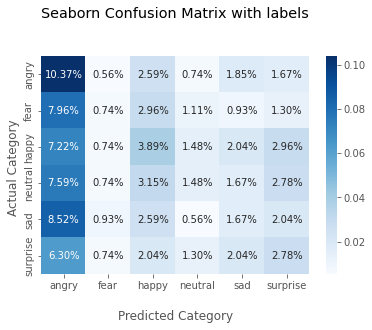

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()